<a href="https://colab.research.google.com/github/thesmokingrobot/11ty-no-style-please/blob/master/research/VIX_Calendars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# VIX Calendars

This notebook supports the webinar here: https://robotwealth.com/rw-pro-webinar-28-nov-2024-vix-calendars/


In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c("roll"), extra_dependencies = c())

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))


googleCloudStorageR installed

Package is already on your system.

Package is already on your system.


R.oo installed


R.utils installed


foreach installed


doParallel installed


xts installed

Package is already on your system.


TTR installed


arrow installed


feather installed

Package is already on your system.



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpwuD9vT/remotese207235b27d/RWLab-rwRtools-c9a75e0/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘rwRtools_0.1.79.tar.gz’




roll installed

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

Authorization successful!

# Get VIX Futures Data

In [3]:
vx <- rwRtools::macro_get_expiring_vx_futures() %>%
  mutate(
    date = as_date(date),
    expiry = as_date(expiry)
  )
vx %>% filter(date == max(date))

ℹ Downloading vx_futures_1d_ohlc.feather

✔ Saved vx_futures_1d_ohlc.feather to macropod/vx_futures_1d_ohlc.feather  ( 7.…





File successfully transferred


ticker,contract_name,date,open,high,low,close,volume,open_interest,tick_size,currency,point_value,margin,type,exchange,expiry
<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<date>
VX-2024Z,CBOE Volatility Index December 2024,2024-11-26,15.40,15.85,15.10,15.2541,66228,0,0.05,USD,1000,7403,Stock Index,CBOE,2024-12-18
VX-2025F,CBOE Volatility Index January 2025,2024-11-26,16.40,16.70,16.20,16.3418,34185,0,0.05,USD,1000,7403,Stock Index,CBOE,2025-01-22
VX-2025G,CBOE Volatility Index February 2025,2024-11-26,16.87,17.10,16.70,16.8001,8038,0,0.05,USD,1000,7403,Stock Index,CBOE,2025-02-19
VX-2025H,CBOE Volatility Index March 2025,2024-11-26,17.15,17.25,17.00,17.0500,4324,0,0.05,USD,1000,7403,Stock Index,CBOE,2025-03-18
VX-2025J,CBOE Volatility Index April 2025,2024-11-26,17.32,17.43,17.19,17.2969,3043,0,0.05,USD,1000,7403,Stock Index,CBOE,2025-04-16
VX-2025K,CBOE Volatility Index May 2025,2024-11-26,17.52,17.62,17.40,17.5899,2533,0,0.05,USD,1000,7403,Stock Index,CBOE,2025-05-21
VX-2025M,CBOE Volatility Index June 2025,2024-11-26,17.73,17.80,17.60,17.7708,572,0,0.05,USD,1000,7403,Stock Index,CBOE,2025-06-18
VX-2025N,CBOE Volatility Index July 2025,2024-11-26,17.97,18.10,17.90,18.0000,47,0,0.05,USD,1000,7403,Stock Index,CBOE,2025-07-16
VX-2025Q,CBOE Volatility Index August 2025,2024-11-26,18.25,18.25,18.20,18.2500,12,0,0.05,USD,1000,7403,Stock Index,CBOE,2025-08-20


Note that VIX futures expire on wednesday morning when the market opens. This will usually be at 8 AM Central Time (CT) - when the cboe opens.

Let's check that those dates are wednesdays.

In [4]:
vx %>%
  mutate(day = lubridate::wday(expiry)) %>%
  group_by(day) %>%
  filter(day != 4) %>%
  group_by(ticker, day) %>%
  summarize(count = n())

`summarise()` has grouped output by 'ticker'. You can override using the
`.groups` argument.


ticker,day,count
<chr>,<dbl>,<int>
VX-2008G,3,252
VX-2014H,3,185
VX-2019H,3,185
VX-2022H,3,186
VX-2024M,3,185
VX-2025H,3,110


A few contracts have expired on Tuesday - including June (VX/M) this month.

# Calculate constant maturity weights

We calculate daily constant maturity futures position by combining the two futures contracts straddling that point and weighting them in inverse proportion to their distance from the desired point.

For example, say we want the 30 day to expiry position.

We would get the closest futures expires in 30 days or fewer.
And the closest future that expires in more than 30 days.

If the closest future is 30 days to expiry, we want 100% weight in that contract and 0% weight in the next contract.

Most of the time, we won't be an isolate a matching contract. So we have to weight each contract as follows:

* t = target time to maturity (any units)
* t1 = time to maturity of first contract (any units)
* t2 = time to maturity of second contract (any units)
* w1 = weight to hold in first contract
* w2 = weight to hold in second contract


w1 = (t2-t) / (t2-t1)

w2 = (t-t1) / (t2-t1)

Of course - sometimes we can't find two contracts that straddle t - esp if it's small or large. In this case we want to return NA as the weights.

And the constant maturity position prices is given by:

P = w1 * p1 + w2 * p2

For each date indentify the t1 and the t2 contract and their weights

In [5]:
# t = constant maturity position (in whatever units you like.)
# data = data frame of raw futures contract data with the following columns:
# - date
# - ticker
# - price
# - tte (time to expiry in the same units as you express t)
get_constant_maturity_weights <- function(t = 30, data) {

   # First get the t1 contract on each date - if there isn't one, that row will be missing
  t1 <- data %>%
    group_by(date) %>%
    mutate(dist_1 = t - tte) %>%
    filter(dist_1 > 0) %>%
    filter(dist_1 == min(dist_1)) %>%
    select(date, ticker_1 = ticker, tte_1 = tte, dist_1, price_1 = price, volume_1 = volume)

  # Next get the t2 contract on each date - if there isn't one, that one will be missing
  t2 <- data %>%
    group_by(date) %>%
    mutate(dist_2 = tte - t) %>%
    filter(dist_2 > 0) %>%
    filter(dist_2 == min(dist_2)) %>%
    select(date, ticker_2 = ticker, tte_2 = tte, dist_2, price_2 = price, volume_2 = volume)

  # Now we can left join to all the dates so we get NA holes where we can construct the series
  series <- data %>%
    distinct(date) %>%
    mutate(t = t) %>%
    left_join(t1, by='date') %>%
    left_join(t2, by='date') %>%
    mutate(
      w_1 = dist_2 / (tte_2 - tte_1), # the weights for ticker_1
      w_2 = dist_1 / (tte_2 - tte_1), # the weights for ticker_2
      effective_maturity = w_1 * tte_1 + w_2 * tte_2, # This should always be t or NA
      price = w_1 * price_1 + w_2 * price_2,
      volume = w_1 * volume_1 + w_2 * volume_2
    )

  # Calculate returns for each contract
  returns <- data %>%
    group_by(ticker) %>%
    arrange(date) %>%
    mutate(
      returns = lead(price) / price - 1
    ) %>%
    na.omit() %>%
    select(ticker, date, returns)

  series %>%
    left_join(returns, by = c("ticker_1" = "ticker", "date" = "date")) %>%
    left_join(returns, by = c("ticker_2" = "ticker", "date" = "date")) %>%
    rename(returns_1 = returns.x, returns_2 = returns.y) %>%
    mutate(returns = w_1 * returns_1 + w_2 * returns_2)
}

Get 60 day constant maturity weights and series

In [6]:
t <- 60

data <- vx %>%
  mutate(
    tte = as.numeric(expiry - date), # time to expiry can be any unit - this example is in days
    price = close,
    volume = volume
   )

const_m <- get_constant_maturity_weights(data, t = t)

const_m %>% tail()

date,t,ticker_1,tte_1,dist_1,price_1,volume_1,ticker_2,tte_2,dist_2,price_2,volume_2,w_1,w_2,effective_maturity,price,volume,returns_1,returns_2,returns
<date>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2024-11-19,60,VX-2024Z,29,31,16.4057,148460,VX-2025F,64,4,17.0007,36746,0.11428571,0.88571429,60,16.93270,49513.31,0.033311593,0.024016658,0.025078936
2024-11-20,60,VX-2024Z,28,32,16.9522,148195,VX-2025F,63,3,17.4090,60938,0.08571429,0.91428571,60,17.36985,68417.17,-0.010653485,-0.007335286,-0.007619703
2024-11-21,60,VX-2024Z,27,33,16.7716,96664,VX-2025F,62,2,17.2813,44662,0.05714286,0.94285714,60,17.25217,47633.54,-0.042106895,-0.025345315,-0.026303120
2024-11-22,60,VX-2024Z,26,34,16.0654,73370,VX-2025F,61,1,16.8433,39902,0.02857143,0.97142857,60,16.82107,40858.23,-0.038355721,-0.024721996,-0.025111531
2024-11-25,60,VX-2025F,58,2,16.4269,35515,VX-2025G,86,26,16.8861,12709,0.92857143,0.07142857,60,16.45970,33886.00,-0.005180527,-0.005092946,-0.005174271
2024-11-26,60,VX-2025F,57,3,16.3418,34185,VX-2025G,85,25,16.8001,8038,0.89285714,0.10714286,60,16.39090,31383.54,NA,NA,NA


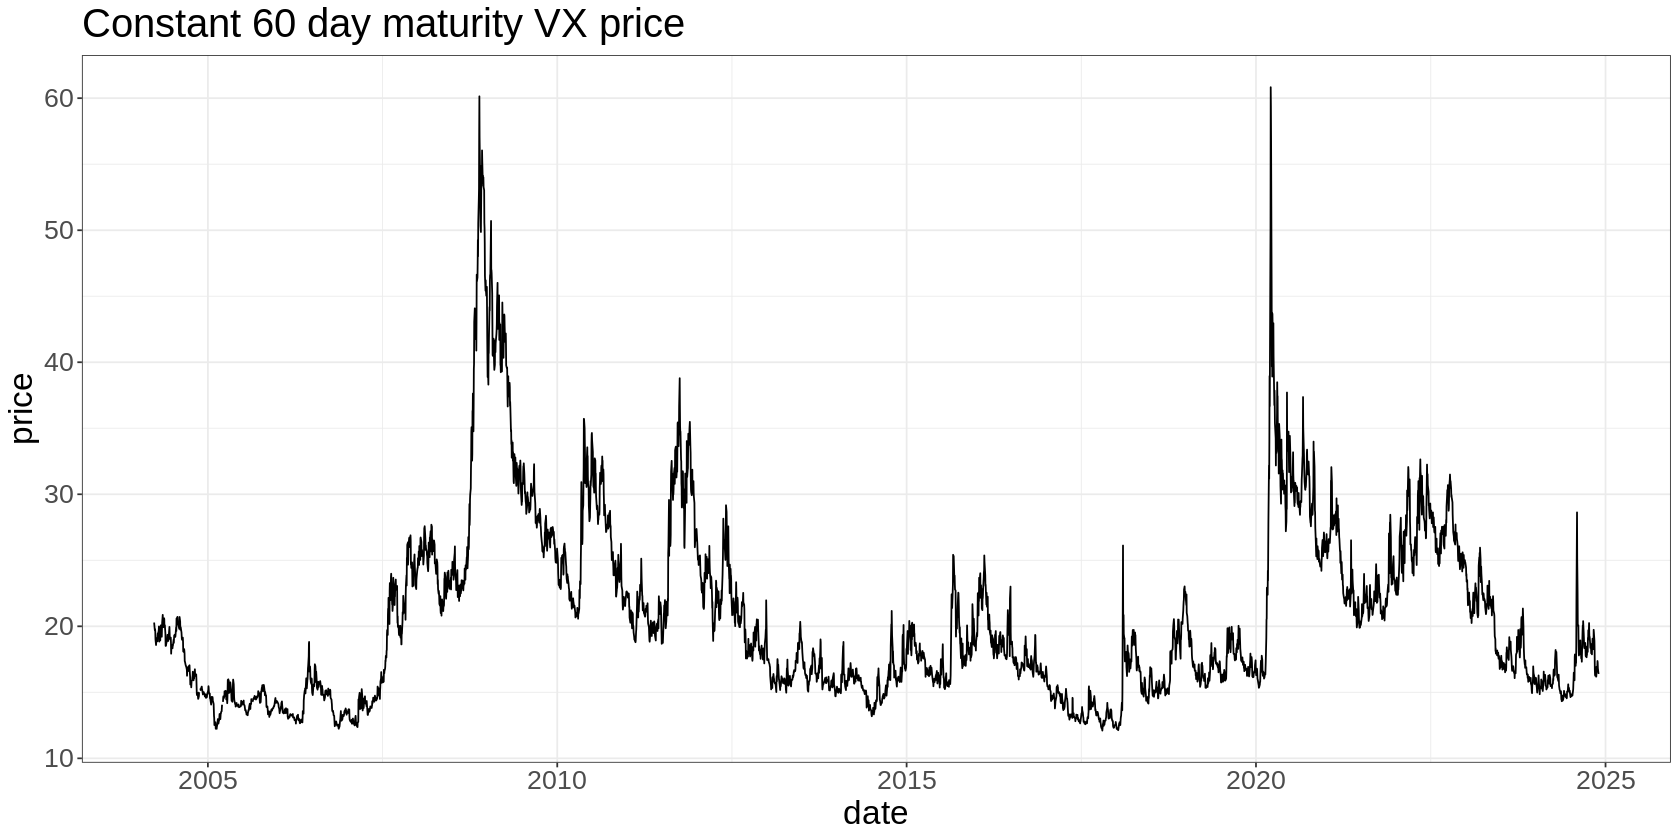

In [7]:
const_m %>%
  ggplot(aes(x=date, y=price)) + geom_line() + ggtitle('Constant 60 day maturity VX price')

You can get multiple series like this

Warning message:
“Removed 16 rows containing missing values or values outside the scale range
(`geom_line()`).”


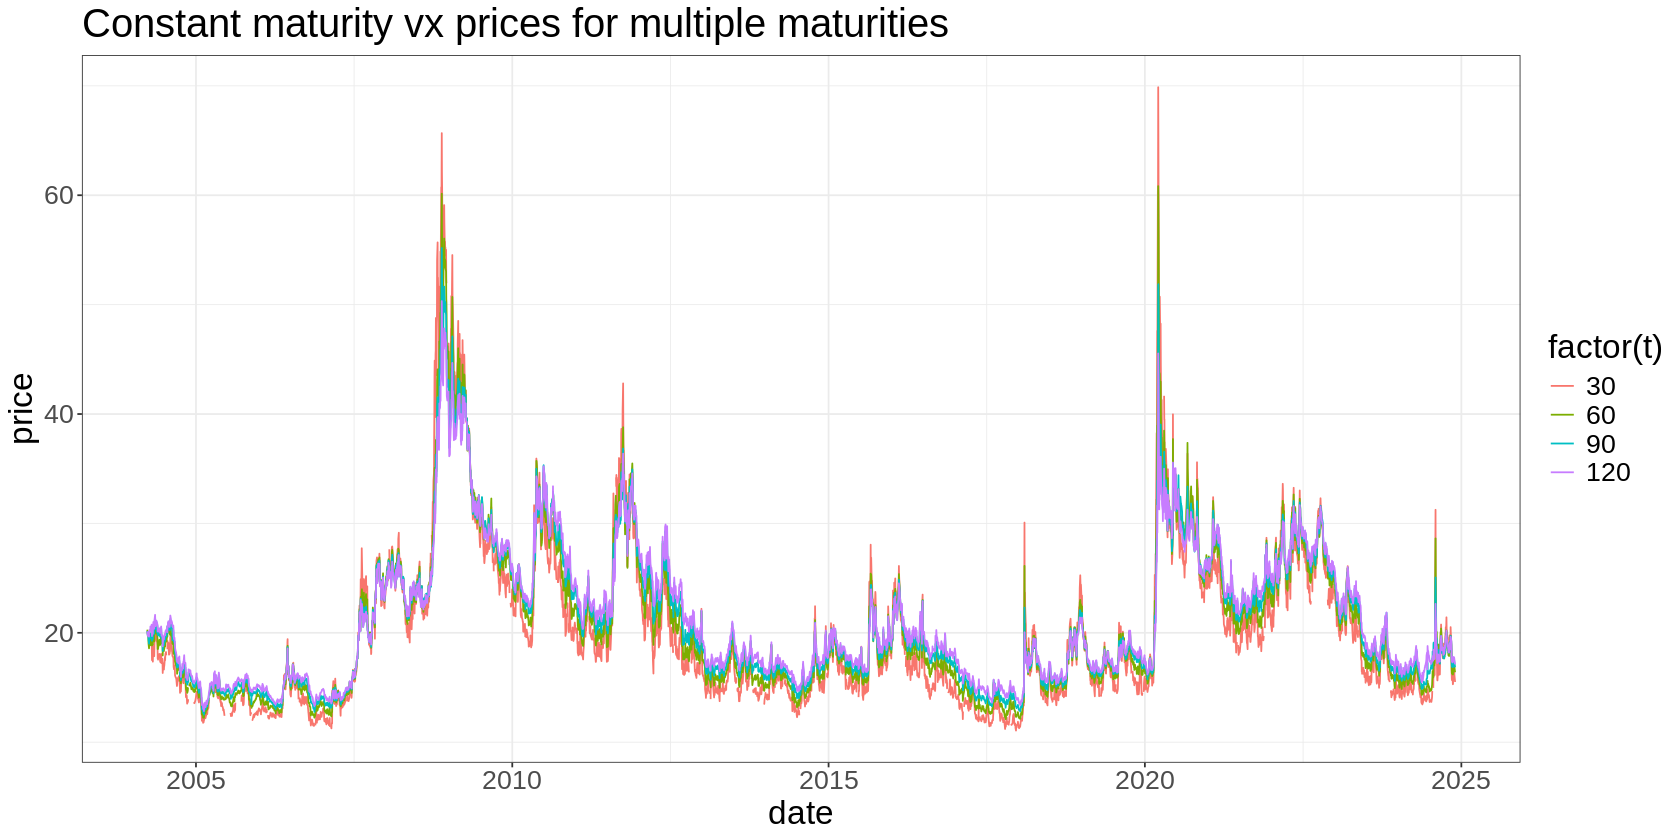

In [8]:
maturities <- c(30,60,90,120)

const_multi <- maturities %>% map_dfr(get_constant_maturity_weights, data = data)

const_multi %>%
  ggplot(aes(x=date, y=price, color=factor(t))) + geom_line() + ggtitle('Constant maturity vx prices for multiple maturities')

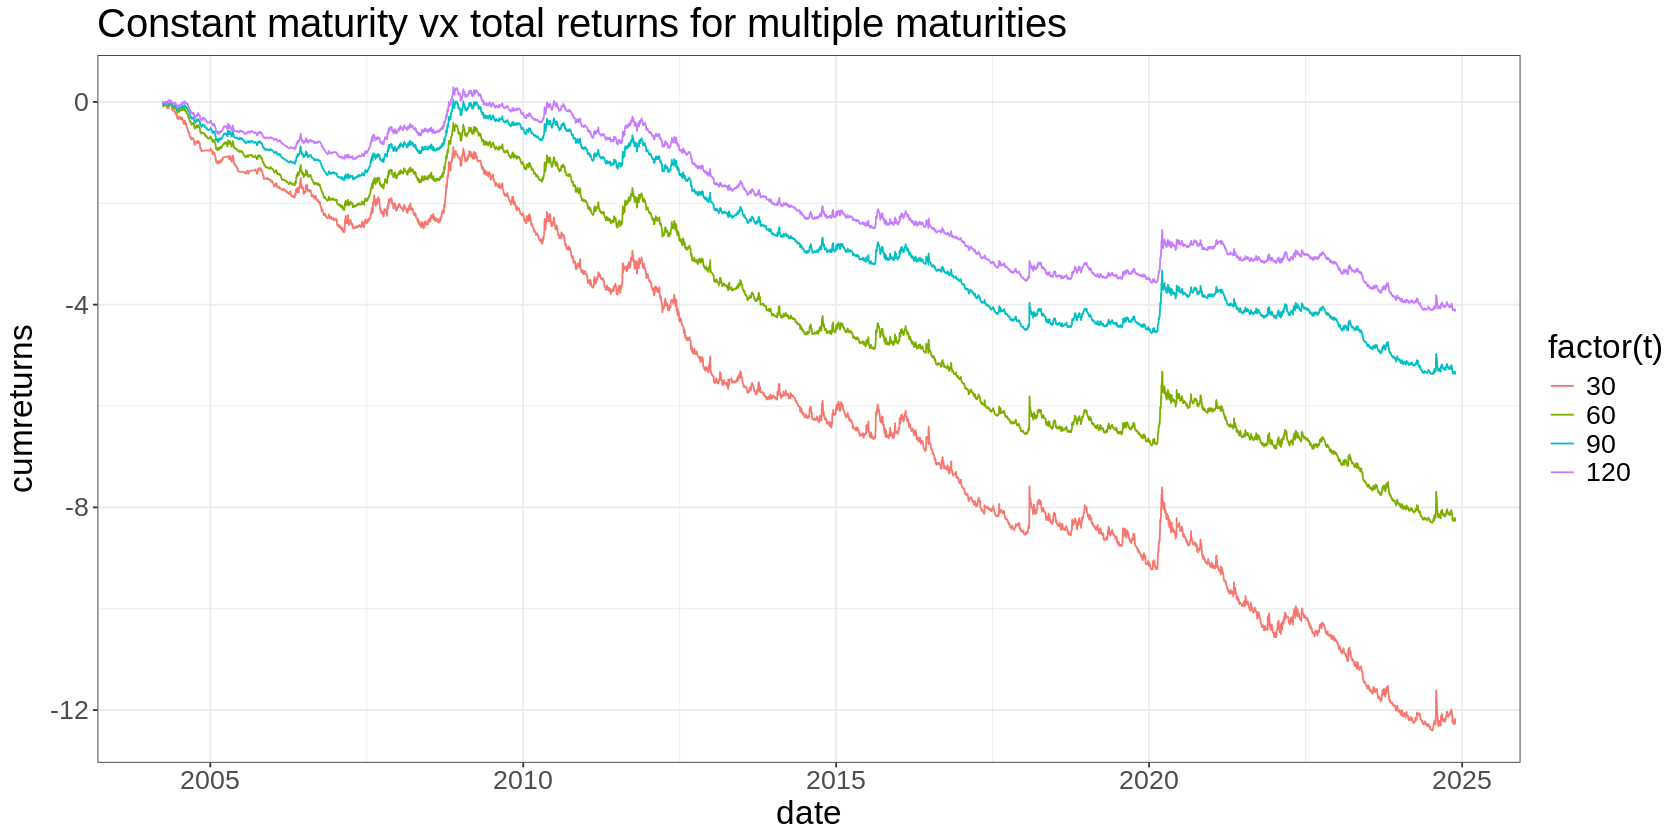

In [9]:
const_multi %>%
  group_by(t) %>%
  arrange(date) %>%
  na.omit() %>%
  mutate(cumreturns = cumsum(log(1+returns))) %>%
  ggplot(aes(x=date, y=cumreturns, color=factor(t))) + geom_line() + ggtitle('Constant maturity vx total returns for multiple maturities')

Let's calculate sharpe ratios

In [10]:
const_multi %>%
  group_by(t) %>%
  arrange(date) %>%
  na.omit() %>%
  summarize(sharpe = (mean(log(1+returns) * 252)) / sd(log(1+returns) * sqrt(252)))

t,sharpe
<dbl>,<dbl>
30,-0.9438457
60,-0.7830437
90,-0.6268585
120,-0.5617934


This is the basic idea... that the front loses money more efficiently than the back.

Let's plot it for each year.

`summarise()` has grouped output by 't'. You can override using the `.groups`
argument.


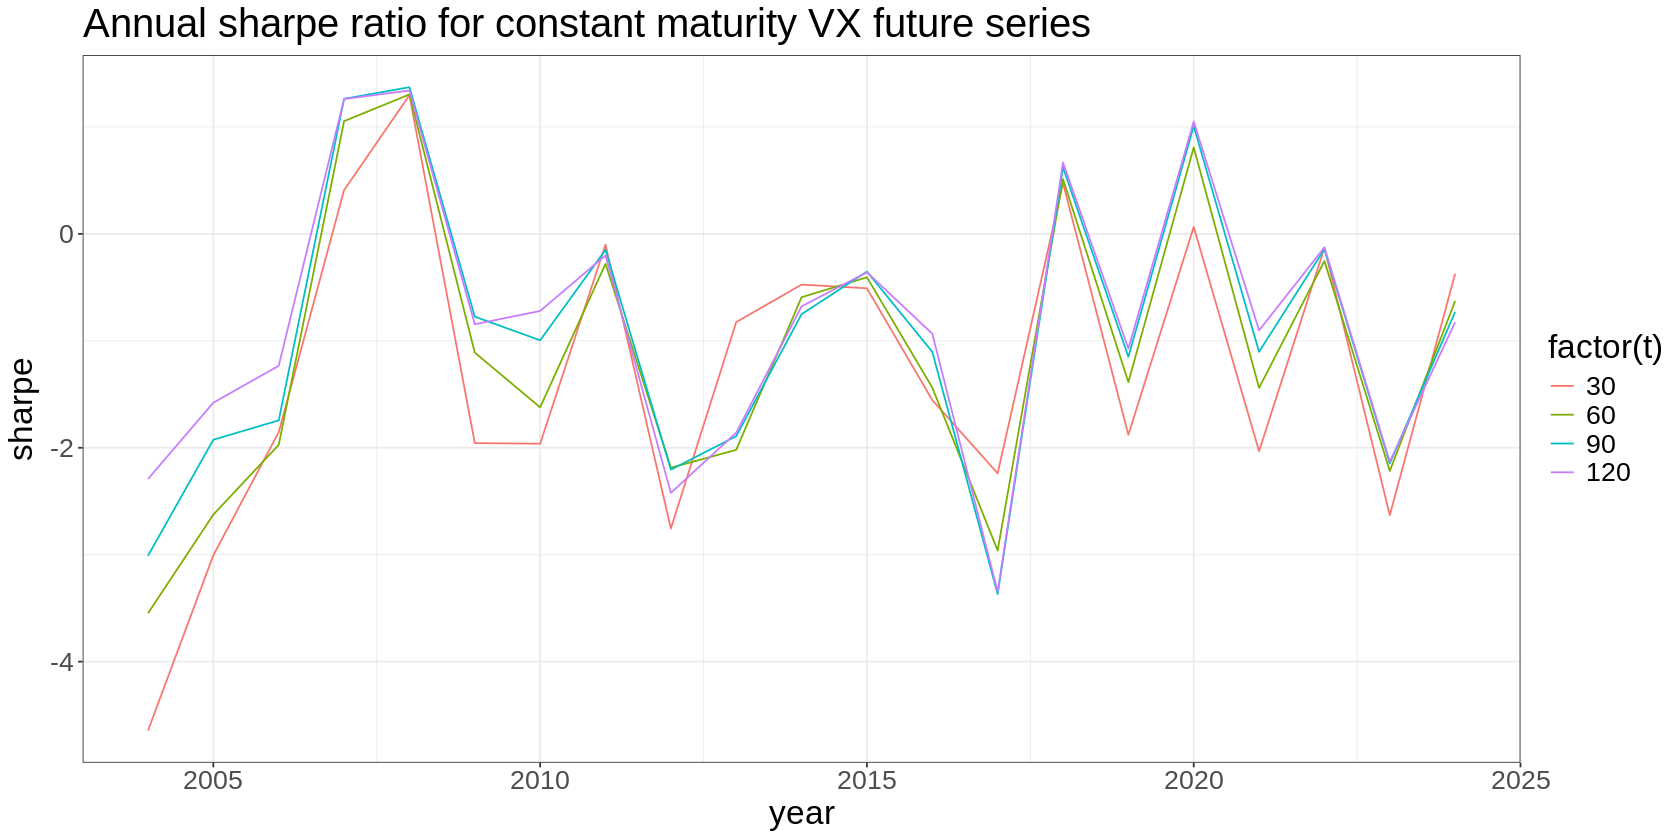

In [11]:
const_multi %>%
  mutate(year = lubridate::year(date)) %>%
  group_by(t, year) %>%
  arrange(date) %>%
  na.omit() %>%
  summarize(sharpe = (mean(log(1+returns) * 252)) / sd(log(1+returns) * sqrt(252))) %>%
  ggplot(aes(x=year, y=sharpe, colour=factor(t))) + geom_line() + ggtitle('Annual sharpe ratio for constant maturity VX future series')

Before we analyze the calendars, let's plot more maturities


Warning message:
“Removed 29 rows containing missing values or values outside the scale range
(`geom_line()`).”


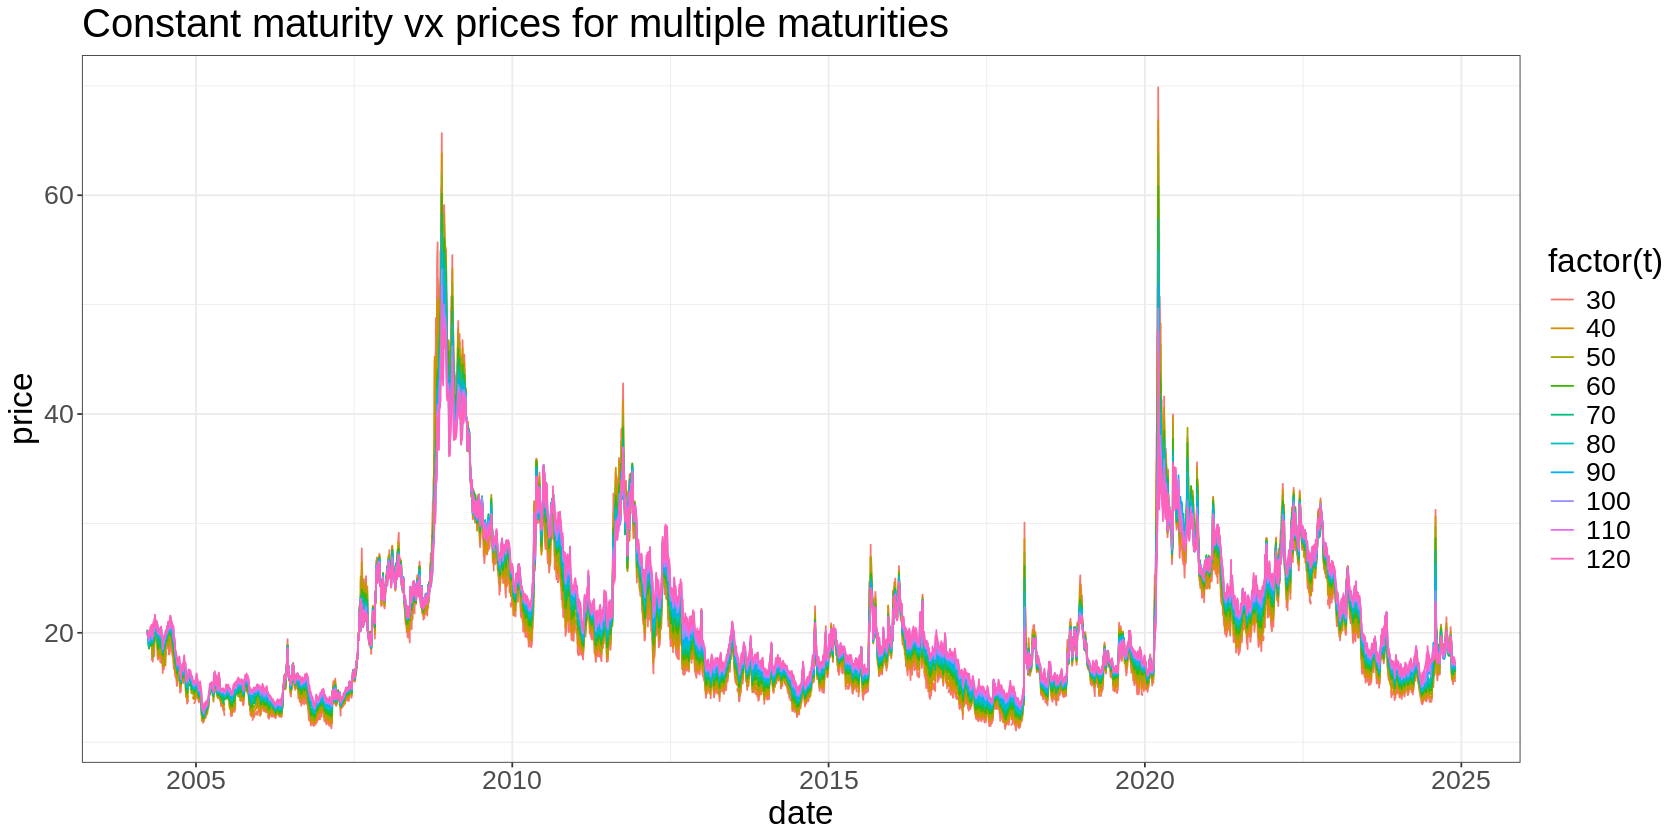

In [15]:
maturities <- c(30,40,50,60,70,80,90,100,110,120)

const_multi <- maturities %>% map_dfr(get_constant_maturity_weights, data = data)

const_multi %>%
  ggplot(aes(x=date, y=price, color=factor(t))) + geom_line() + ggtitle('Constant maturity vx prices for multiple maturities')

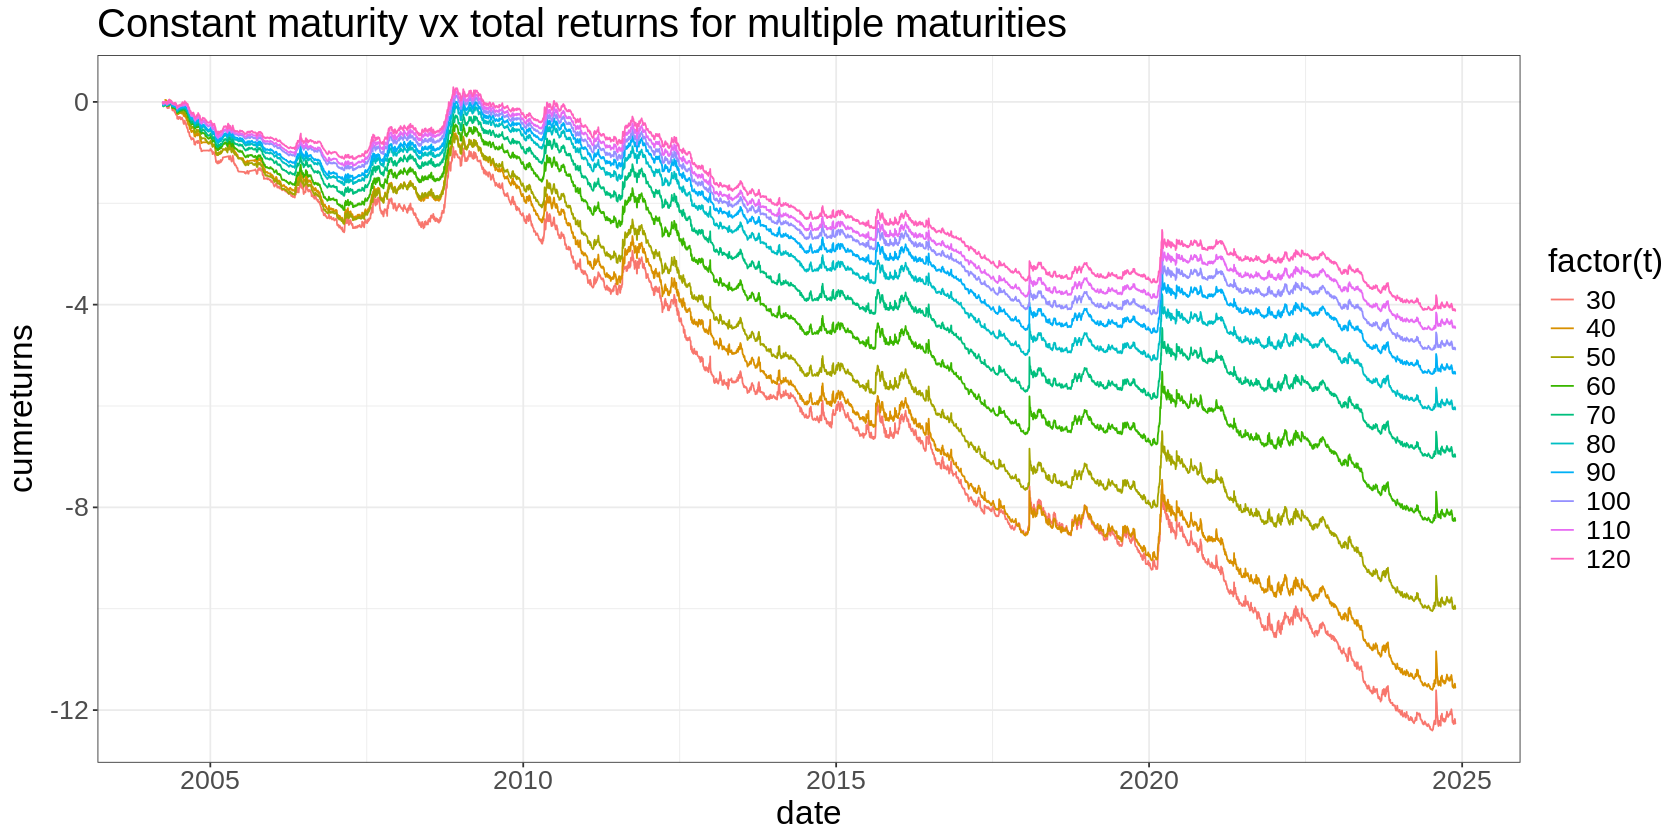

In [16]:
const_multi %>%
  group_by(t) %>%
  arrange(date) %>%
  na.omit() %>%
  mutate(cumreturns = cumsum(log(1+returns))) %>%
  ggplot(aes(x=date, y=cumreturns, color=factor(t))) + geom_line() + ggtitle('Constant maturity vx total returns for multiple maturities')

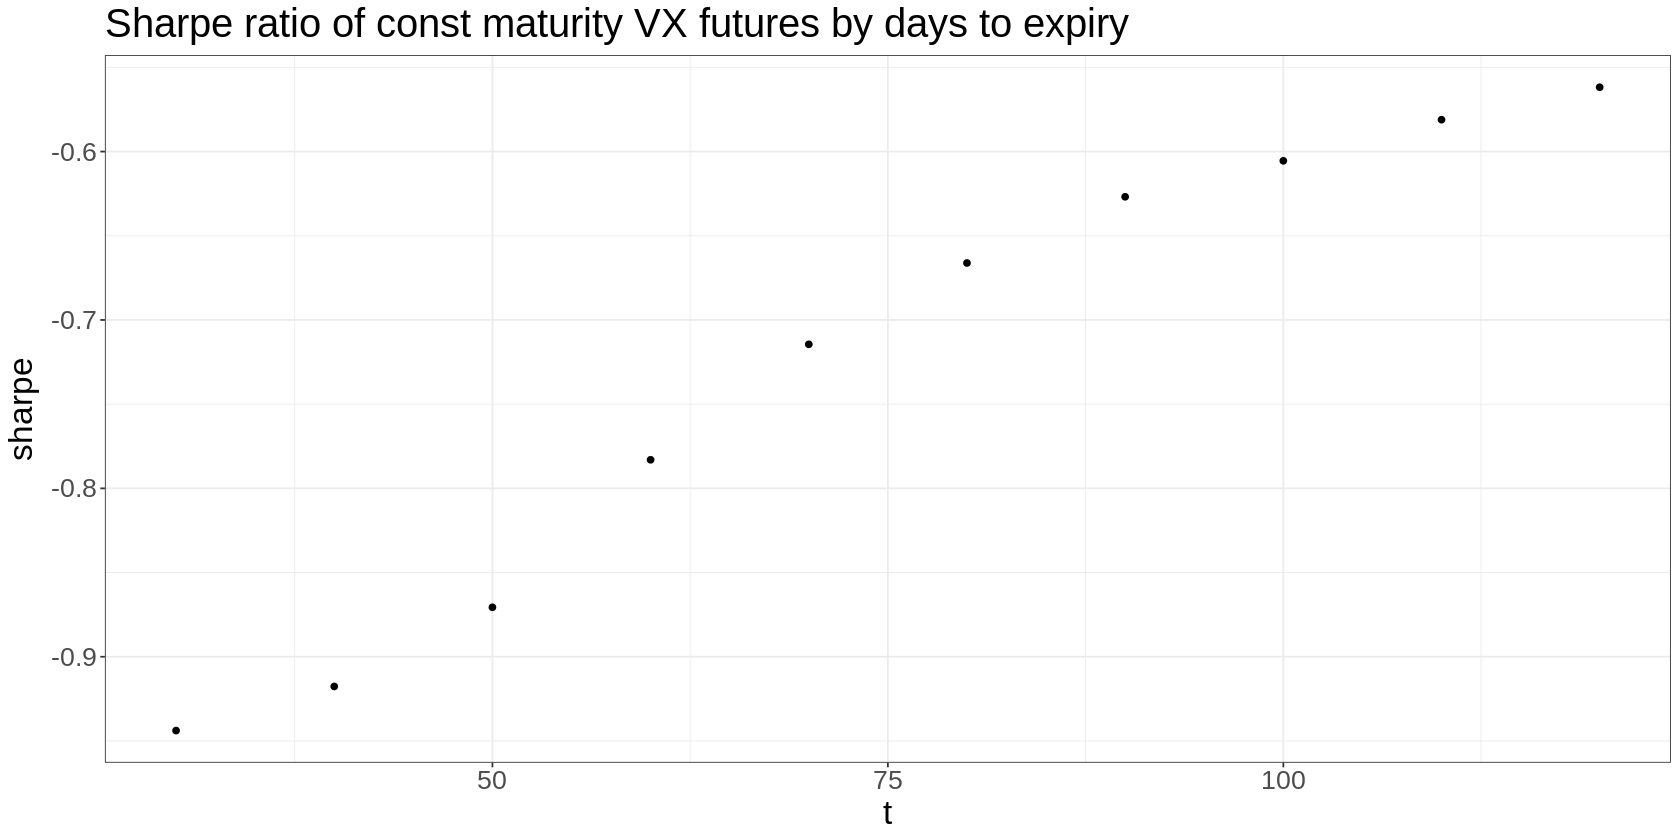

In [20]:
const_multi %>%
  group_by(t) %>%
  arrange(date) %>%
  na.omit() %>%
  summarize(sharpe = (mean(log(1+returns) * 252)) / sd(log(1+returns) * sqrt(252))) %>%
  ggplot(aes(x=t, y=sharpe)) + geom_point() + ggtitle('Sharpe ratio of const maturity VX futures by days to expiry')

We can analyze the calendars.

Let's do this naively first

We'll look at calendars spaced a month a part cos you can do that easiest
 - short 30 / long 60
 - short 40 / long 70
 - short 50 / long 80
 - short 60 / long 90
 - short 70 / long 100
 - short 80 / long 110
 - short 90 / long 120


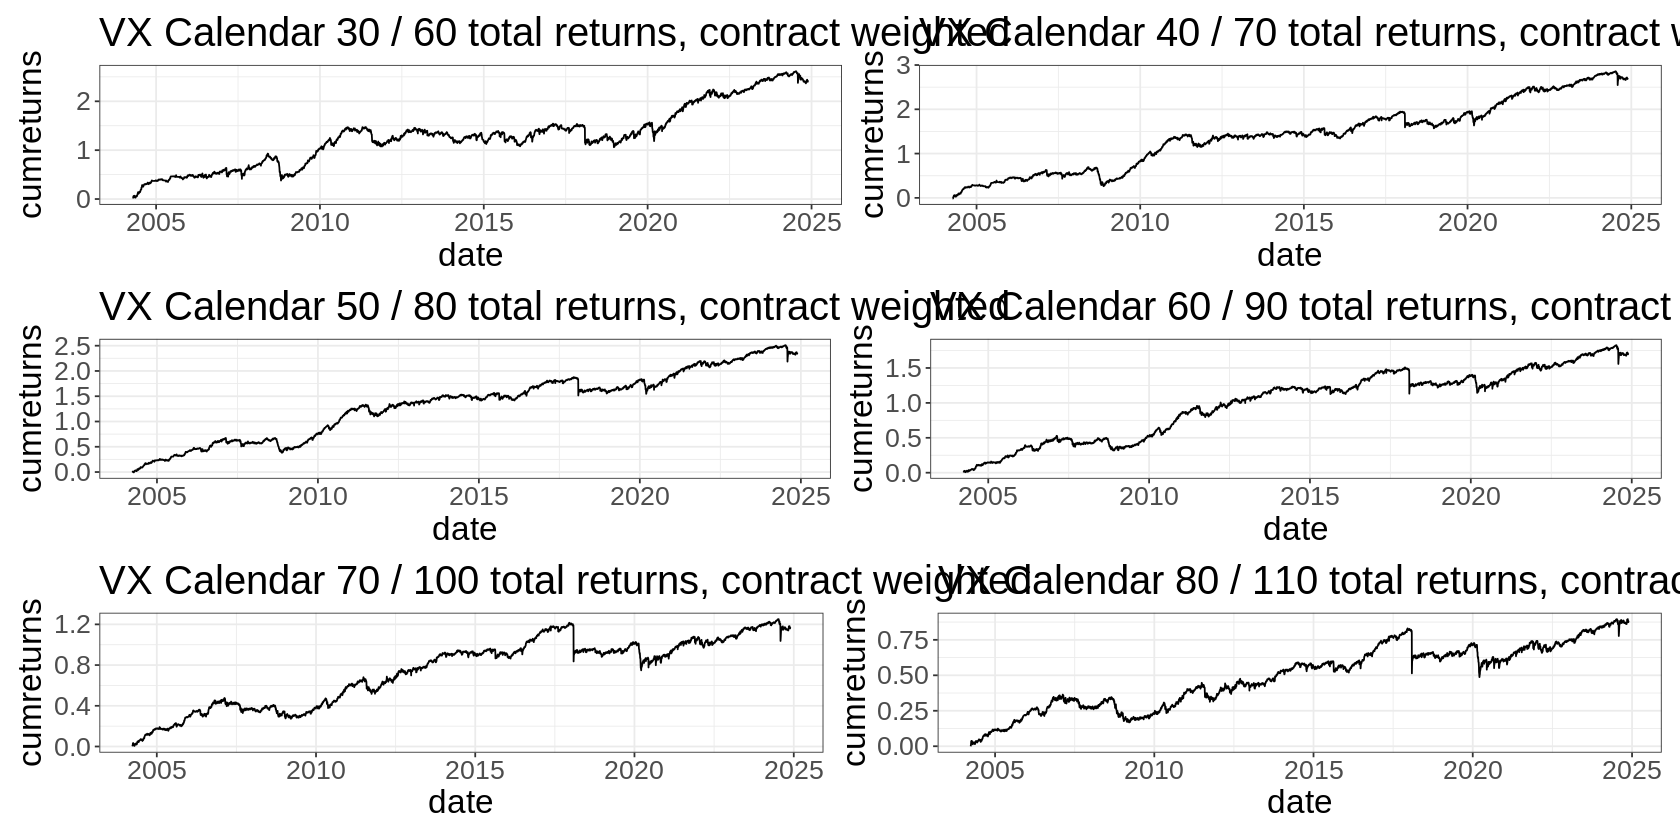

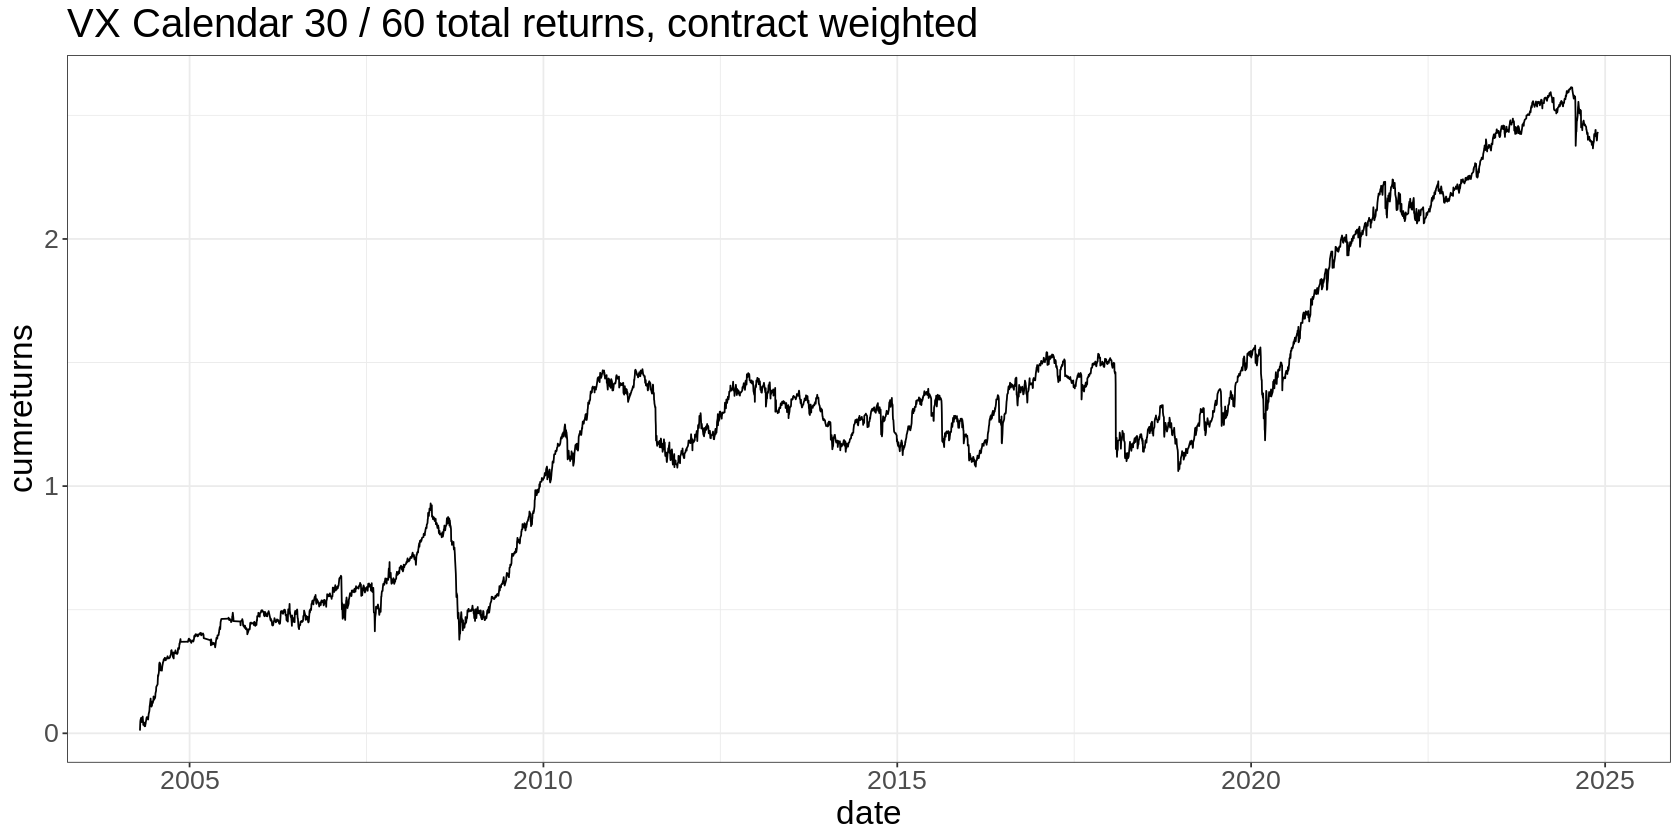

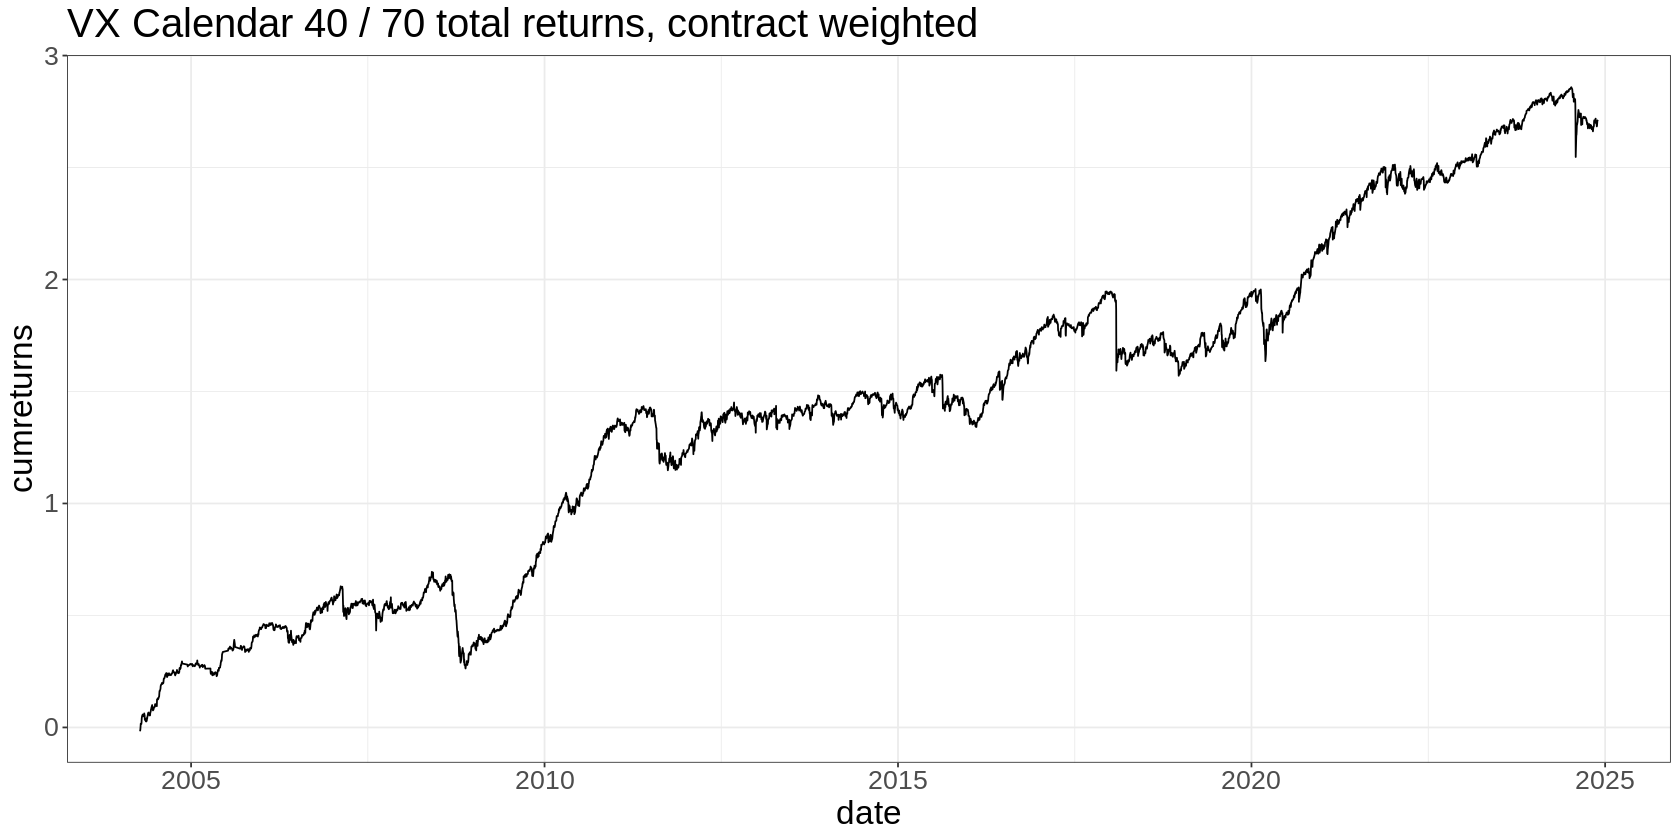

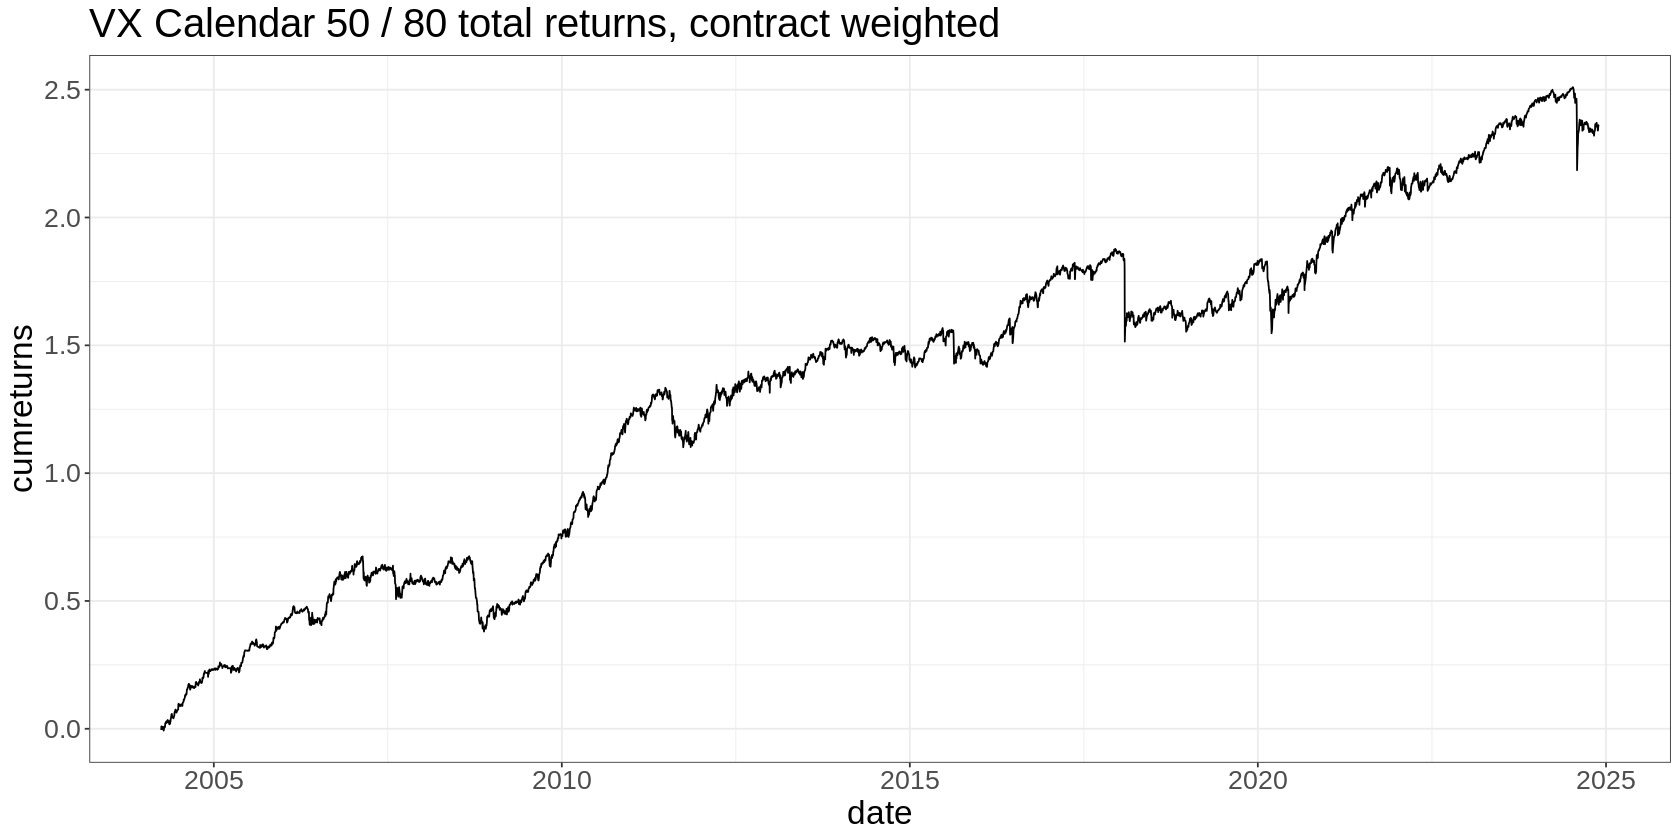

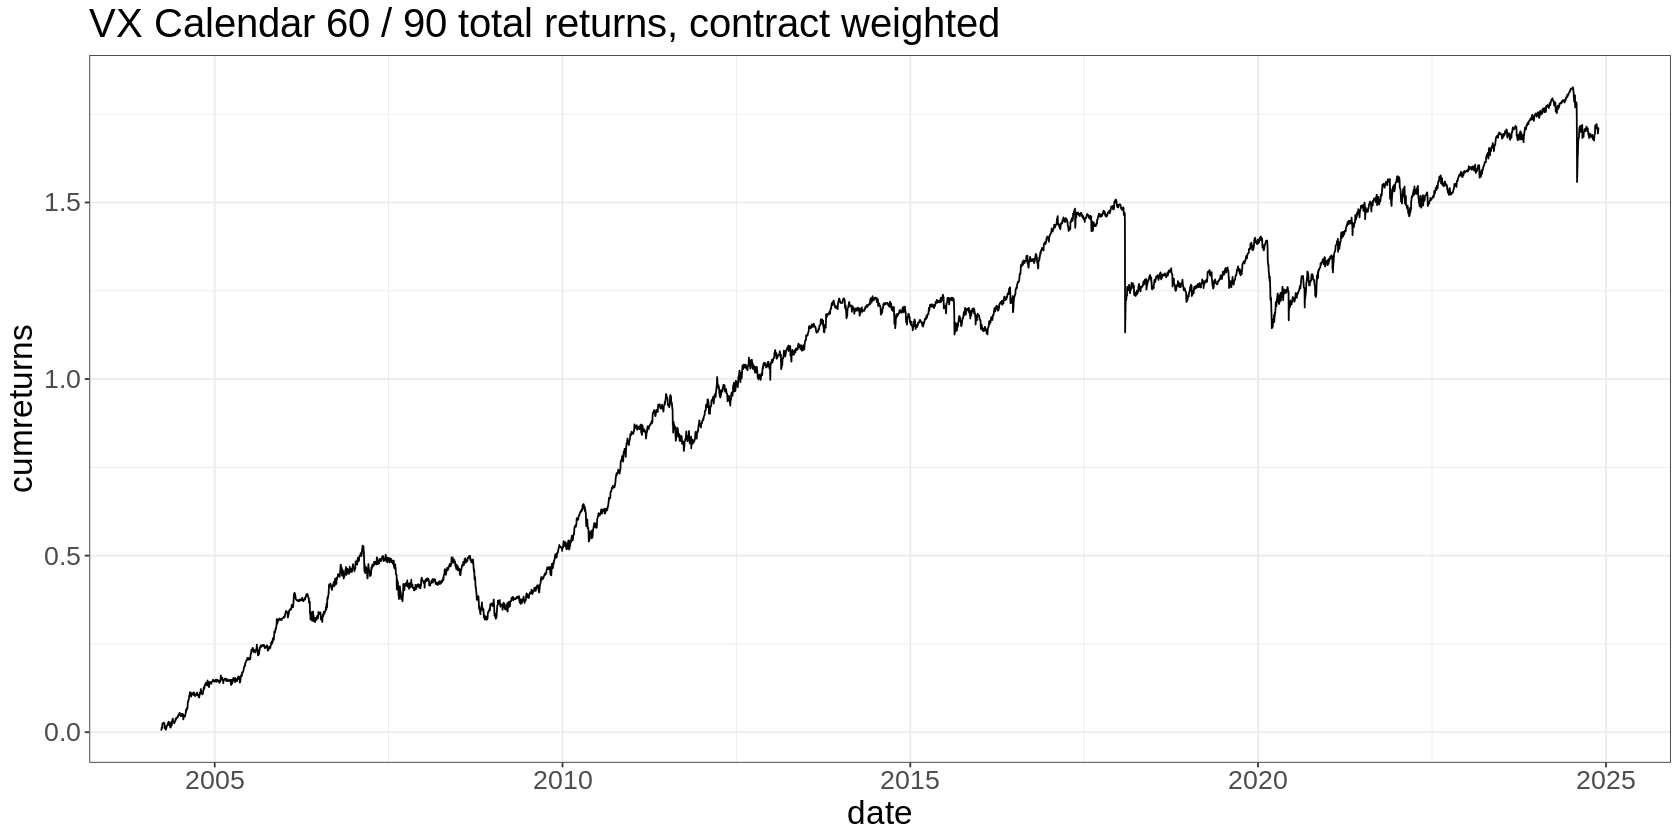

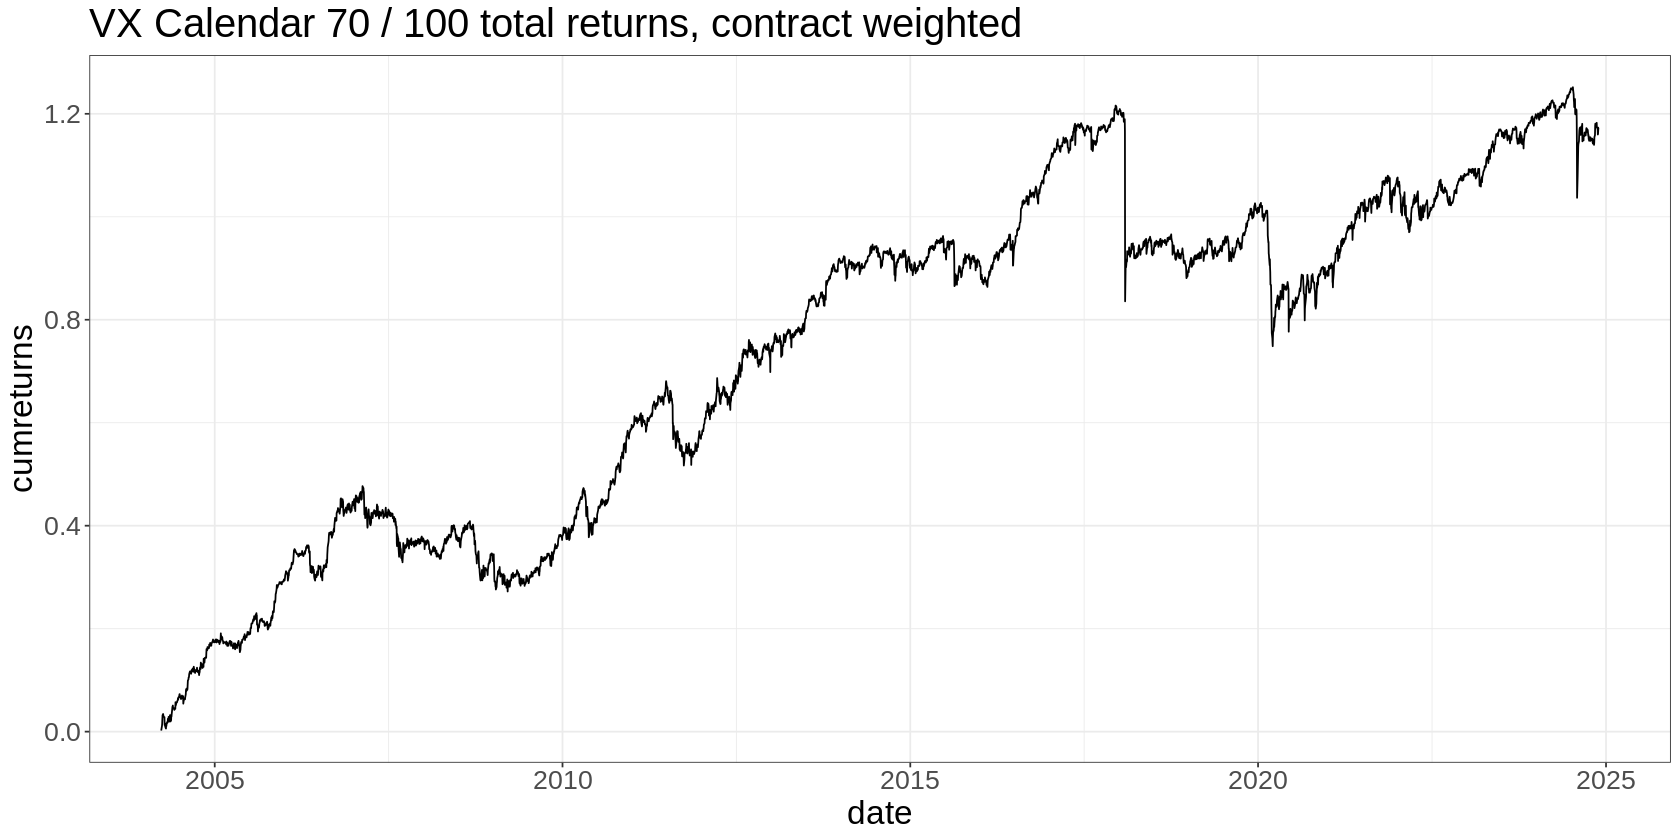

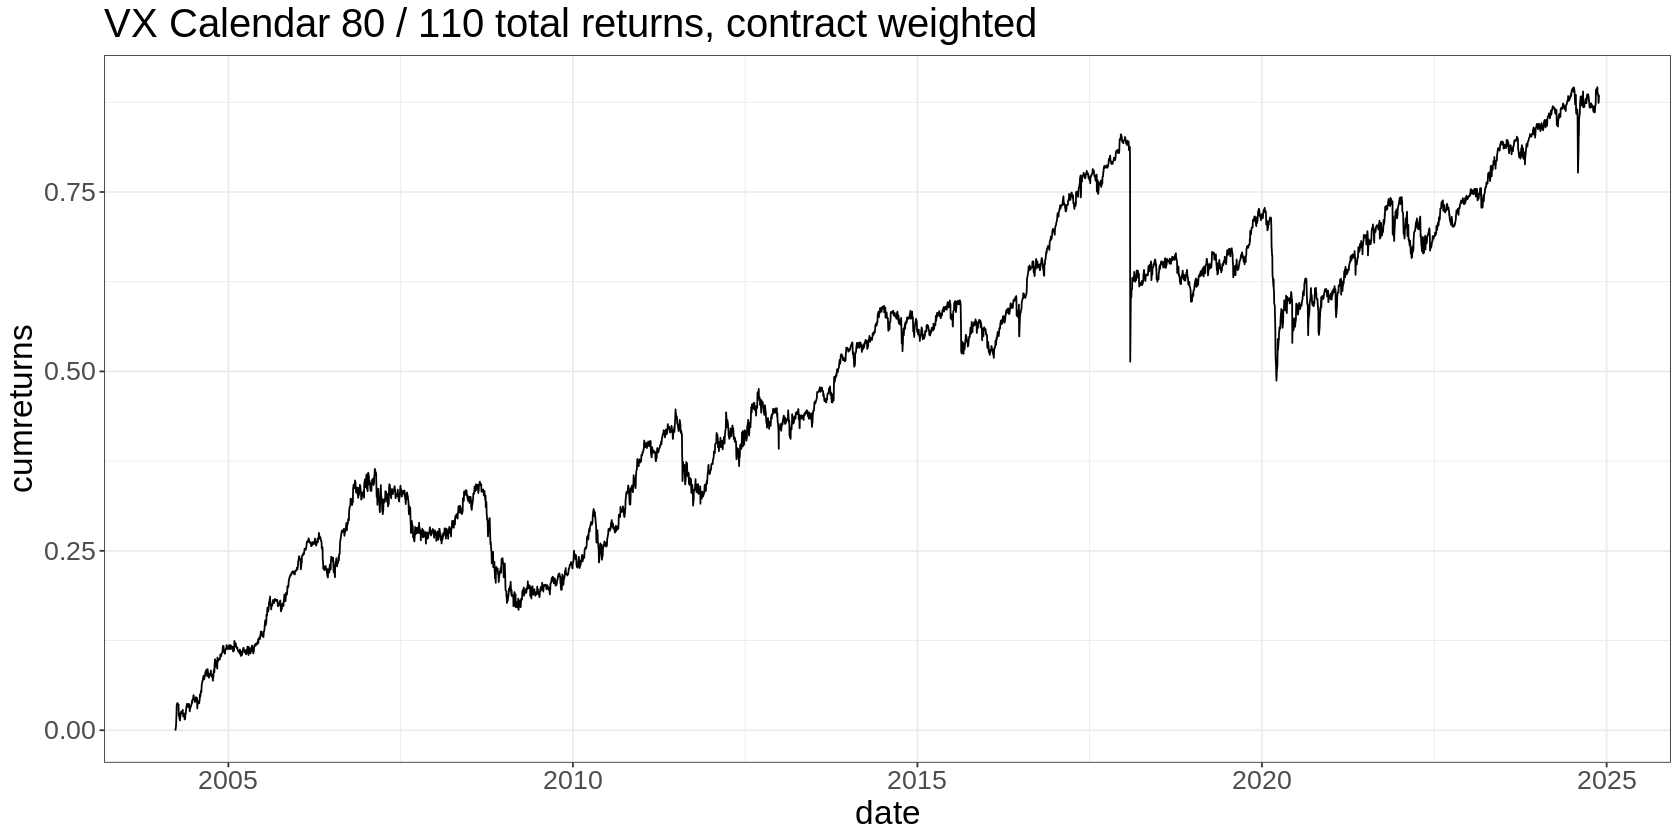

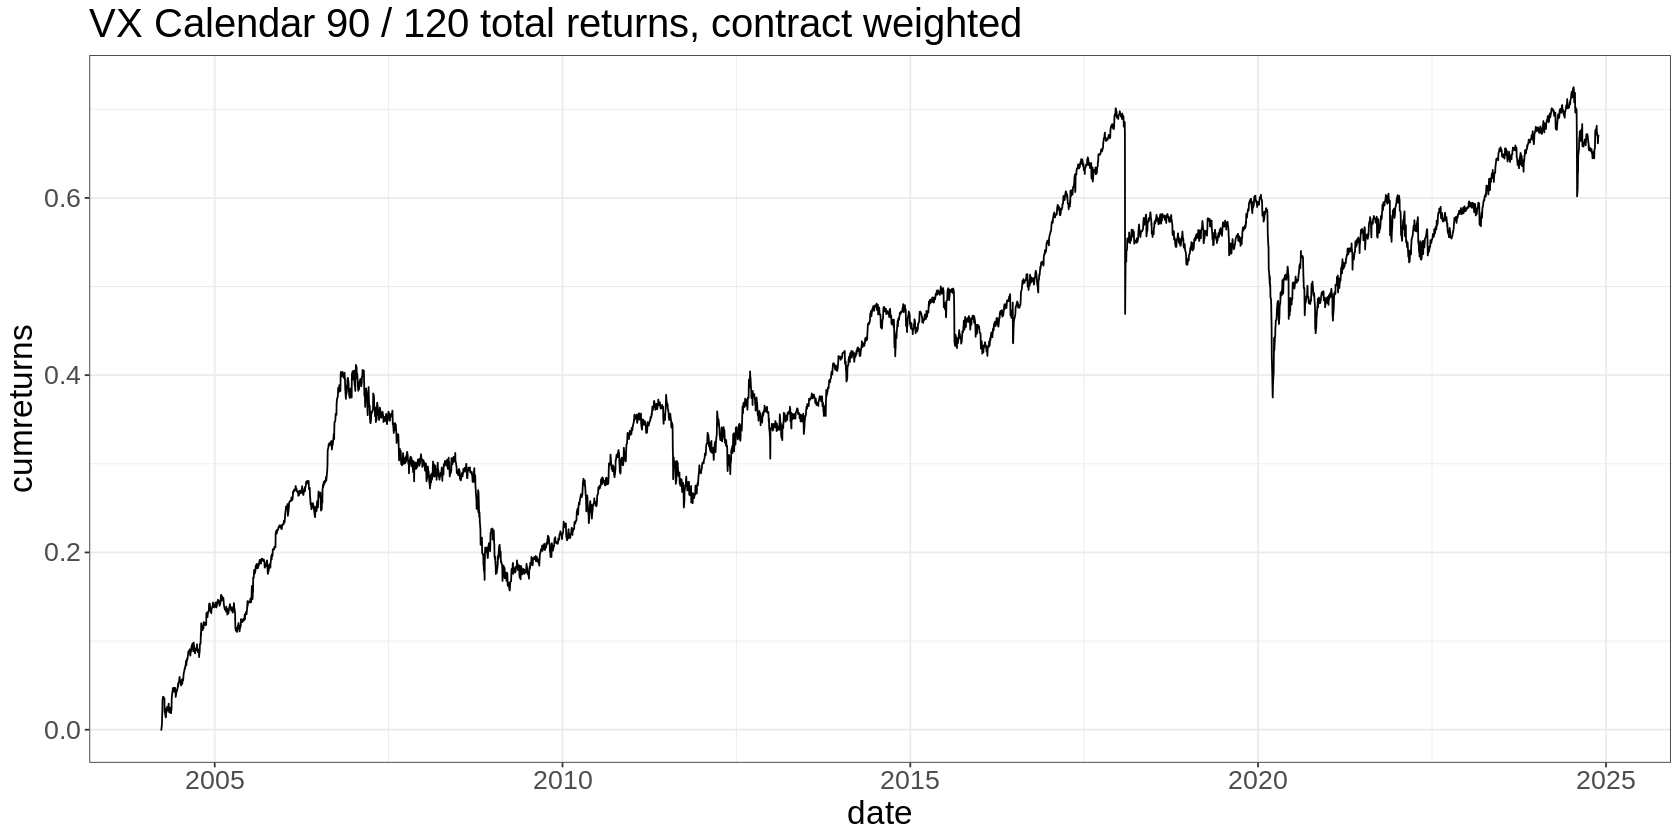

In [27]:
calendar_returns <- function(data, t_1, t_2) {
  front <- data %>% filter(t==t_1) %>% mutate(front_returns = -returns) %>% select(date, front_returns)
  back <- data %>% filter(t==t_2) %>% mutate(back_returns = returns) %>% select(date, back_returns)
  front %>% left_join(back, by='date') %>% mutate(returns = front_returns + back_returns)
}

plot_calendar_returns <- function(data, t_1, t_2) {
  calendar_returns(const_multi, t_1, t_2) %>%
    na.omit() %>%
    arrange(date) %>%
    mutate(cumreturns = cumsum(log(1+returns))) %>%
    ggplot(aes(x=date, y=cumreturns)) + geom_line() + ggtitle(glue::glue('VX Calendar {t_1} / {t_2} total returns, contract weighted'))
}

install.packages('patchwork')
library(patchwork)

plot1 <- plot_calendar_returns(const_multi, 30, 60)
plot2 <- plot_calendar_returns(const_multi, 40, 70)
plot3 <- plot_calendar_returns(const_multi, 50, 80)
plot4 <- plot_calendar_returns(const_multi, 60, 90)
plot5 <- plot_calendar_returns(const_multi, 70, 100)
plot6 <- plot_calendar_returns(const_multi, 80, 110)
plot7 <- plot_calendar_returns(const_multi, 90, 120)

# Combine the plots in two columns
combined_plot <- (plot1 | plot2) /
                 (plot3 | plot4) /
                 (plot5 | plot6)
print(combined_plot)

print(plot1)
print(plot2)
print(plot3)
print(plot4)
print(plot5)
print(plot6)
print(plot7)




Now we can look at the same thing where we target a constant volatility or beta in both legs.

Let's make both legs 20 vol.

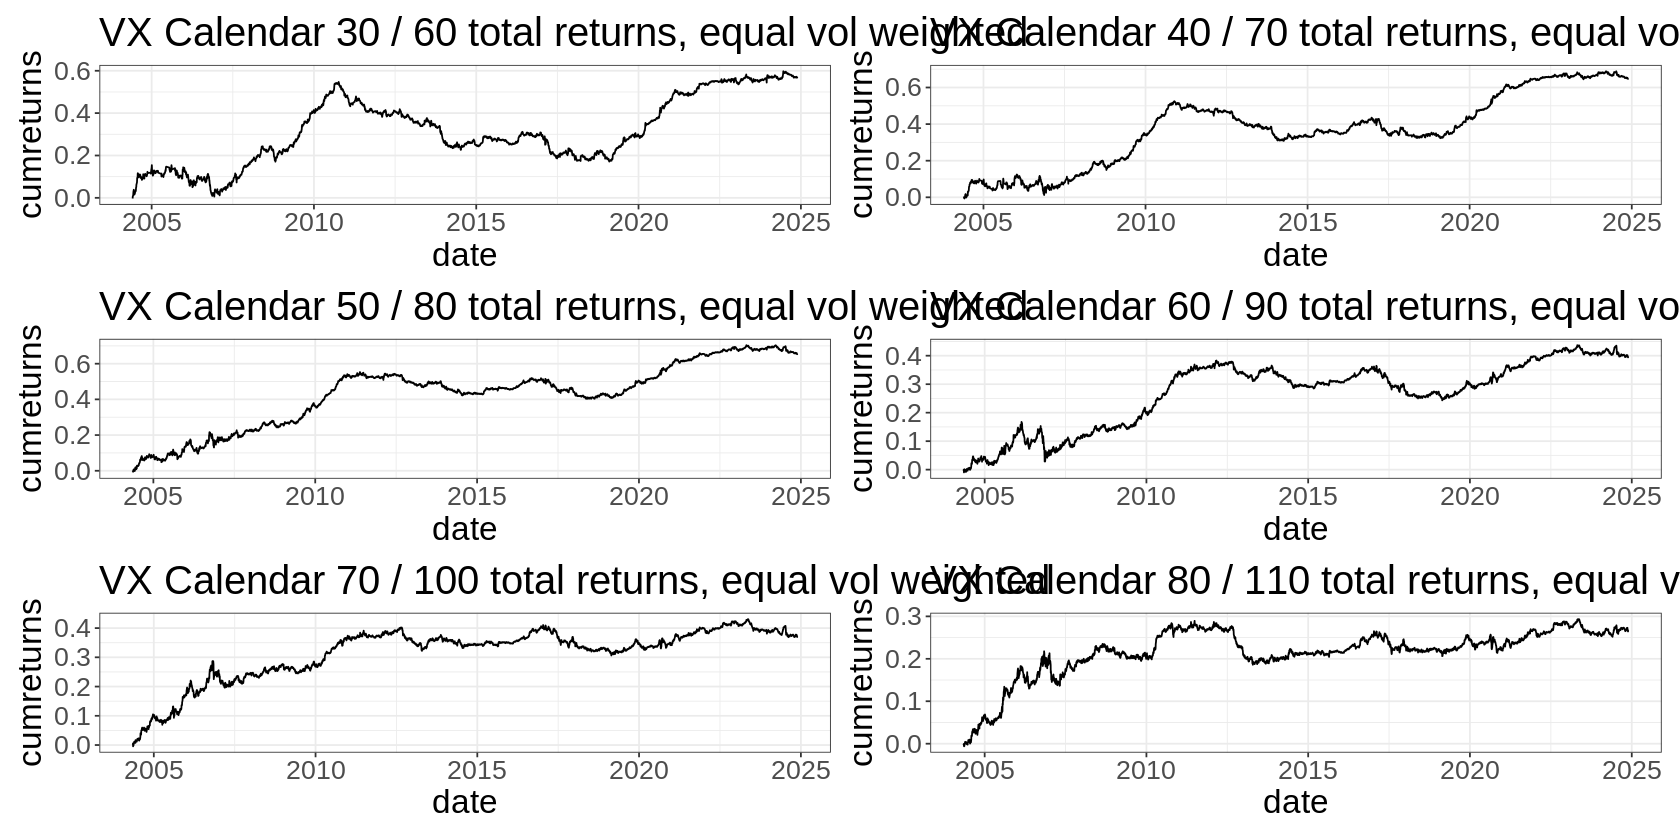

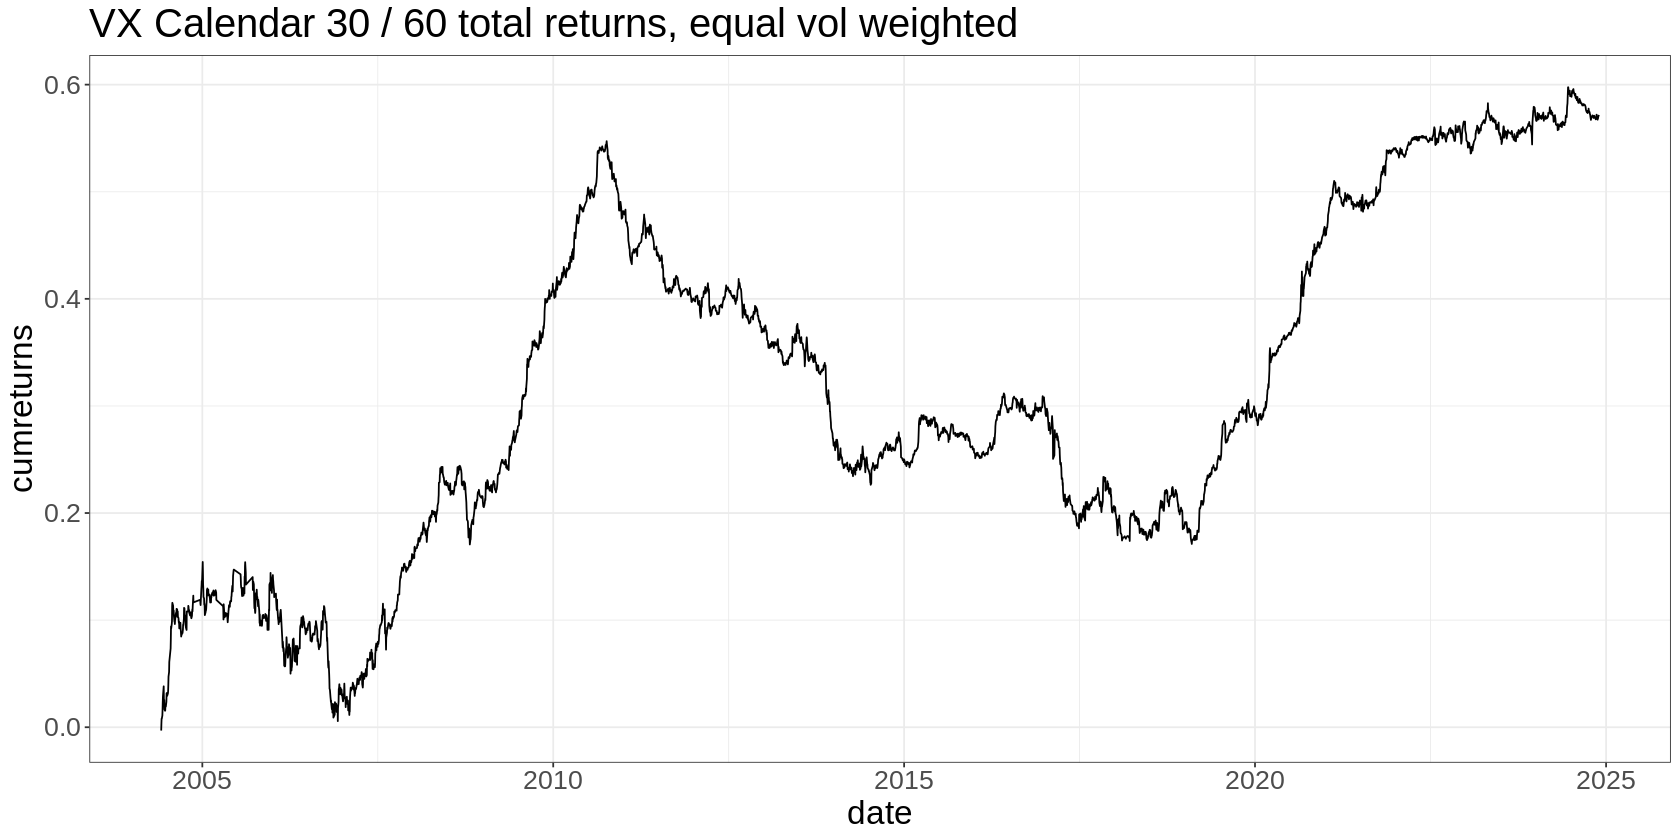

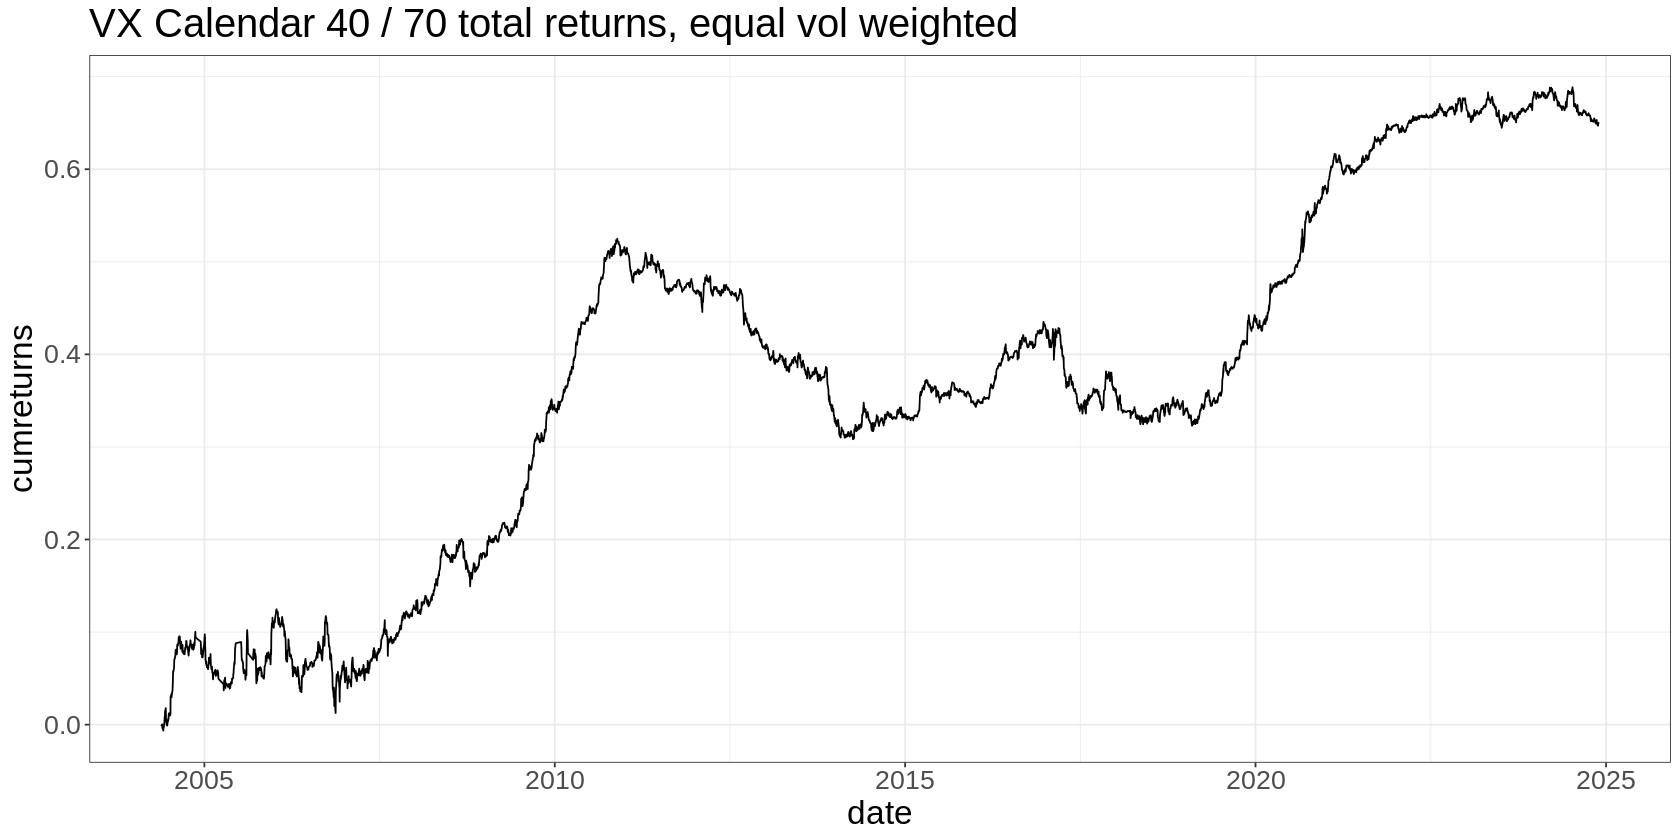

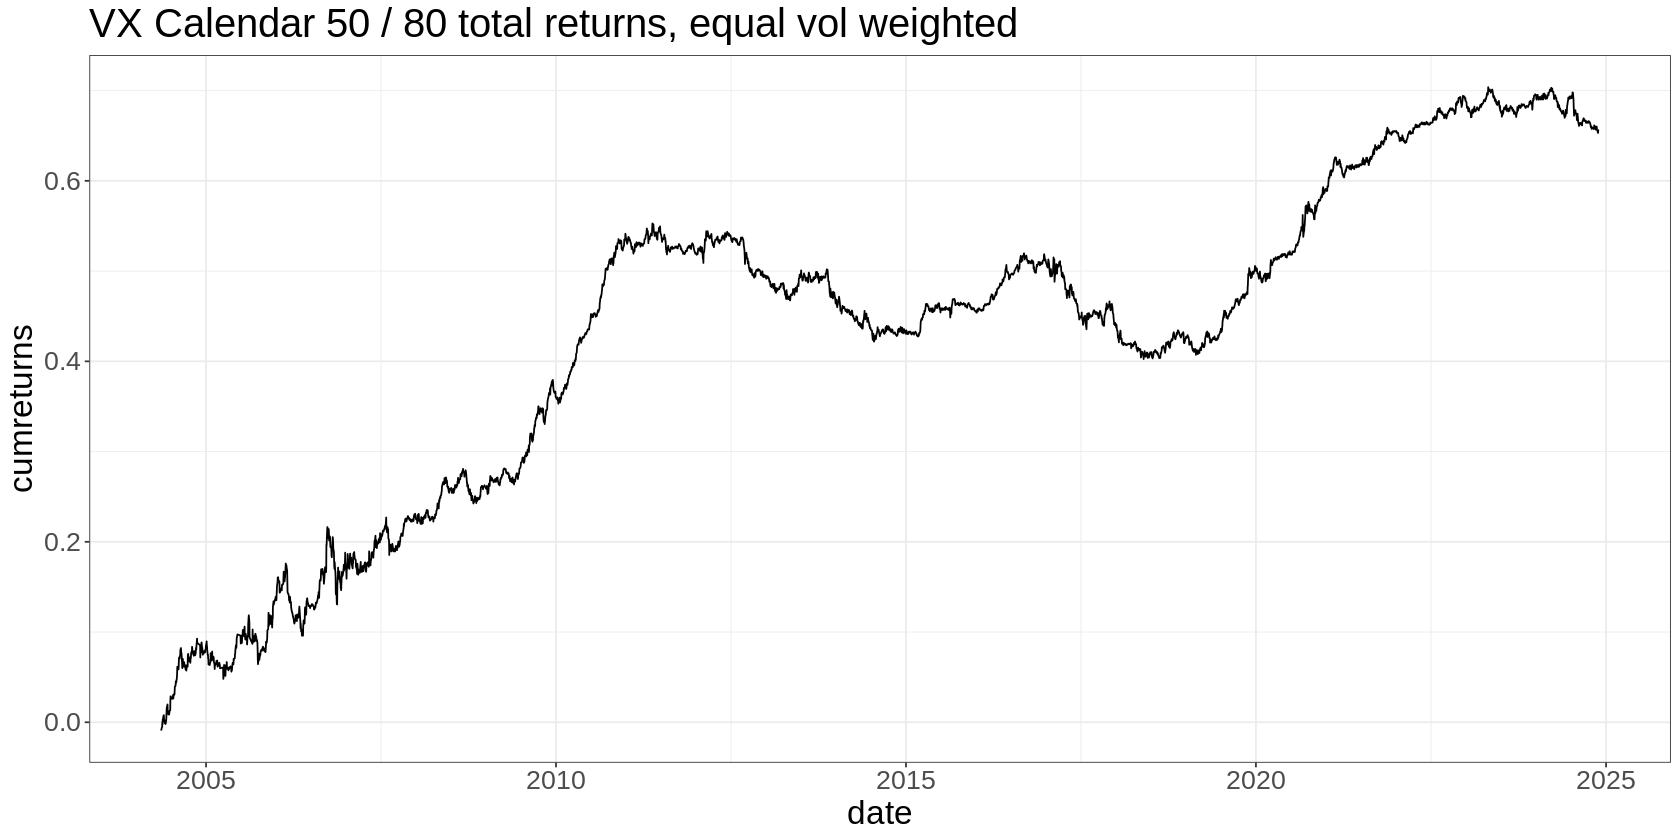

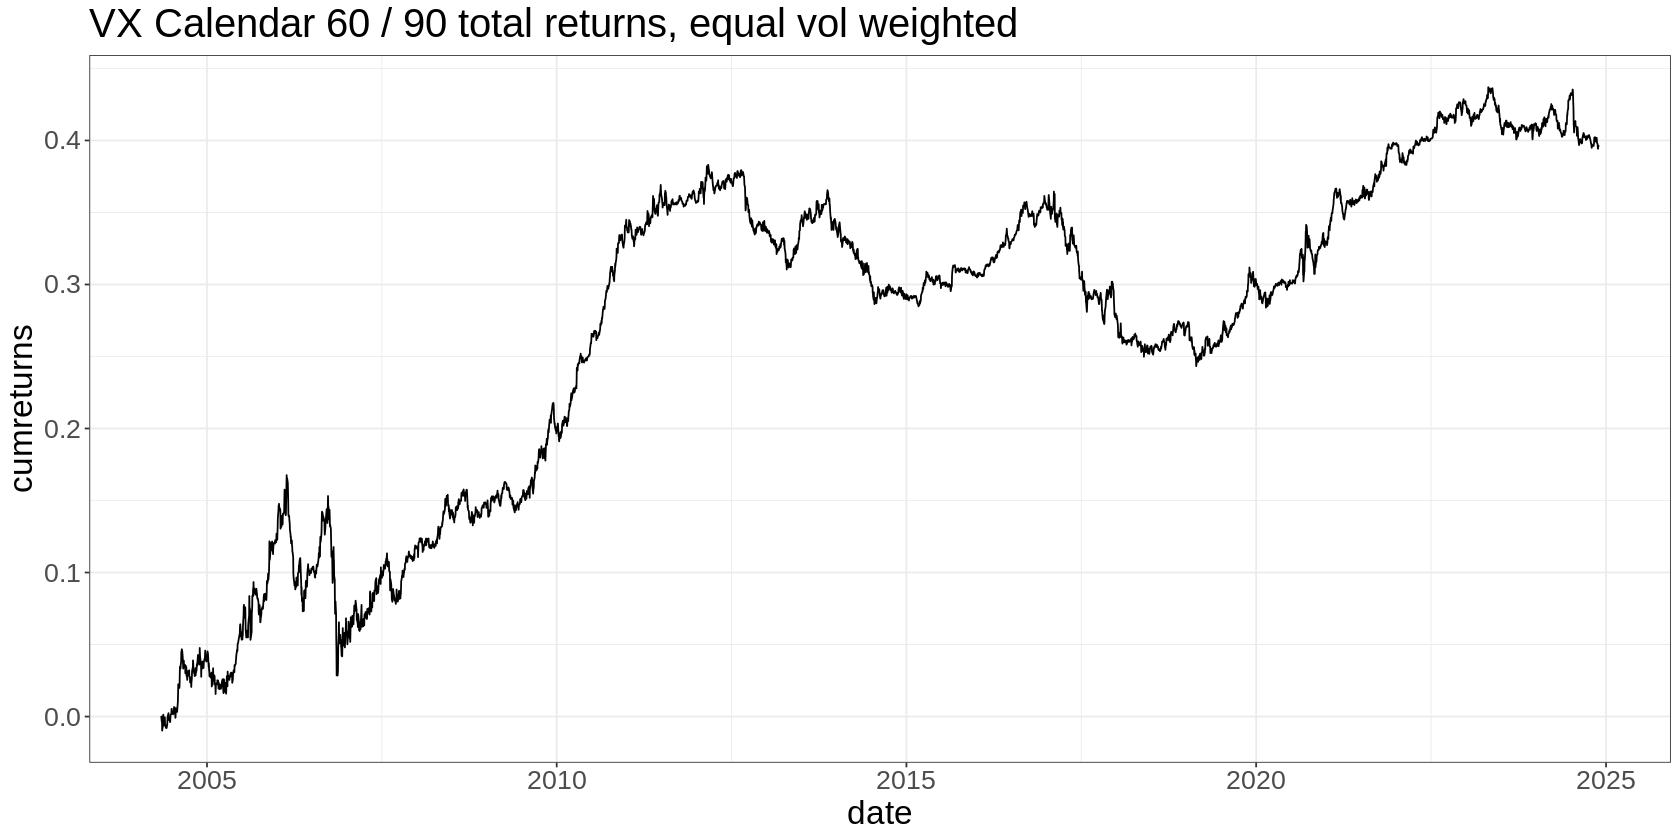

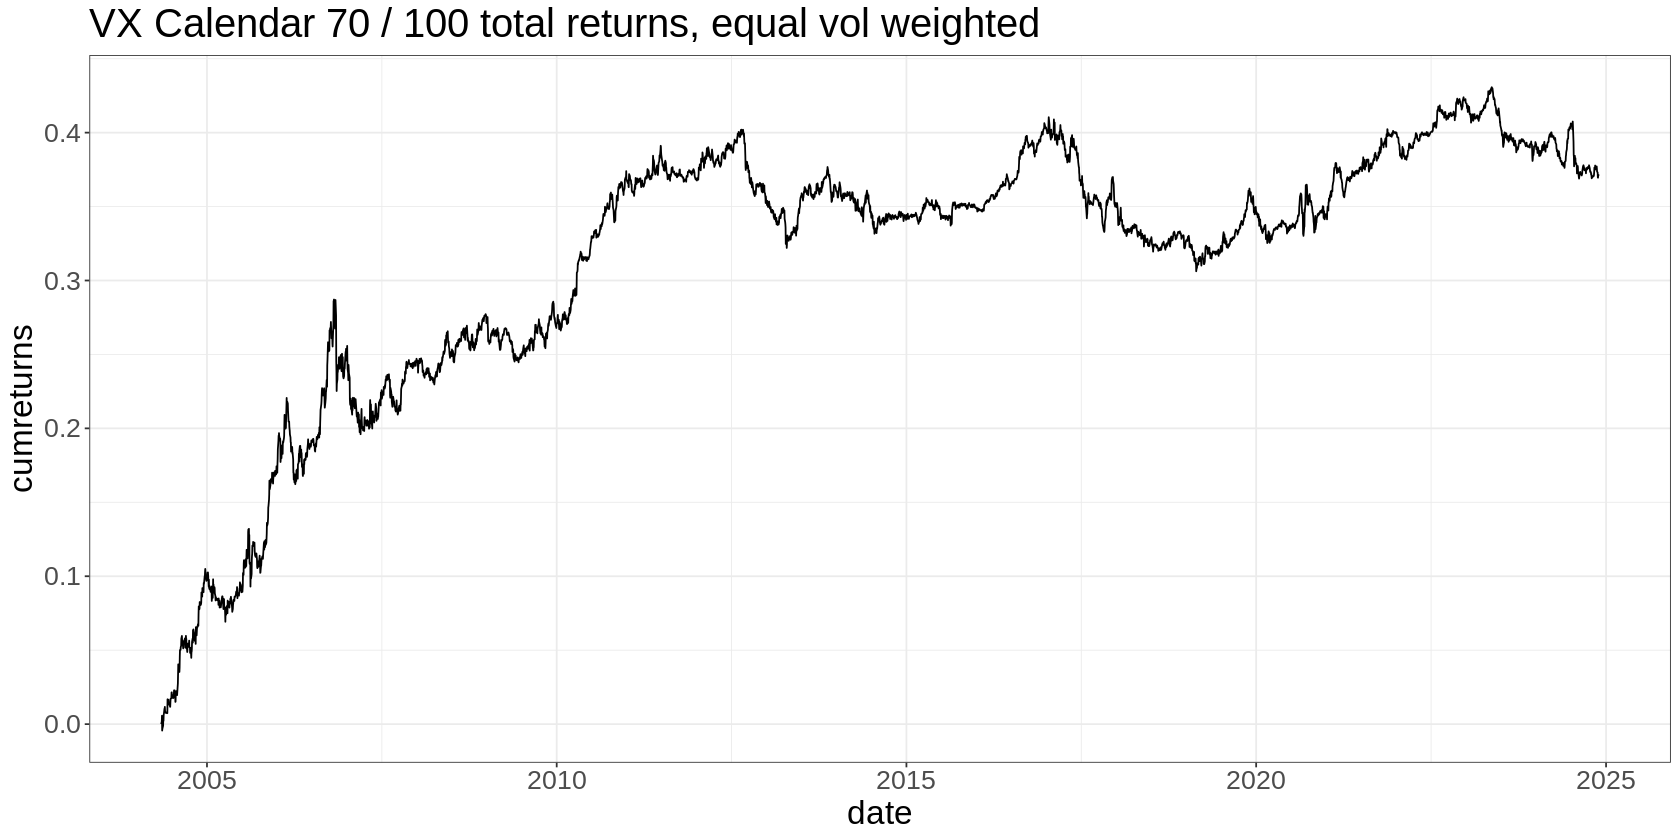

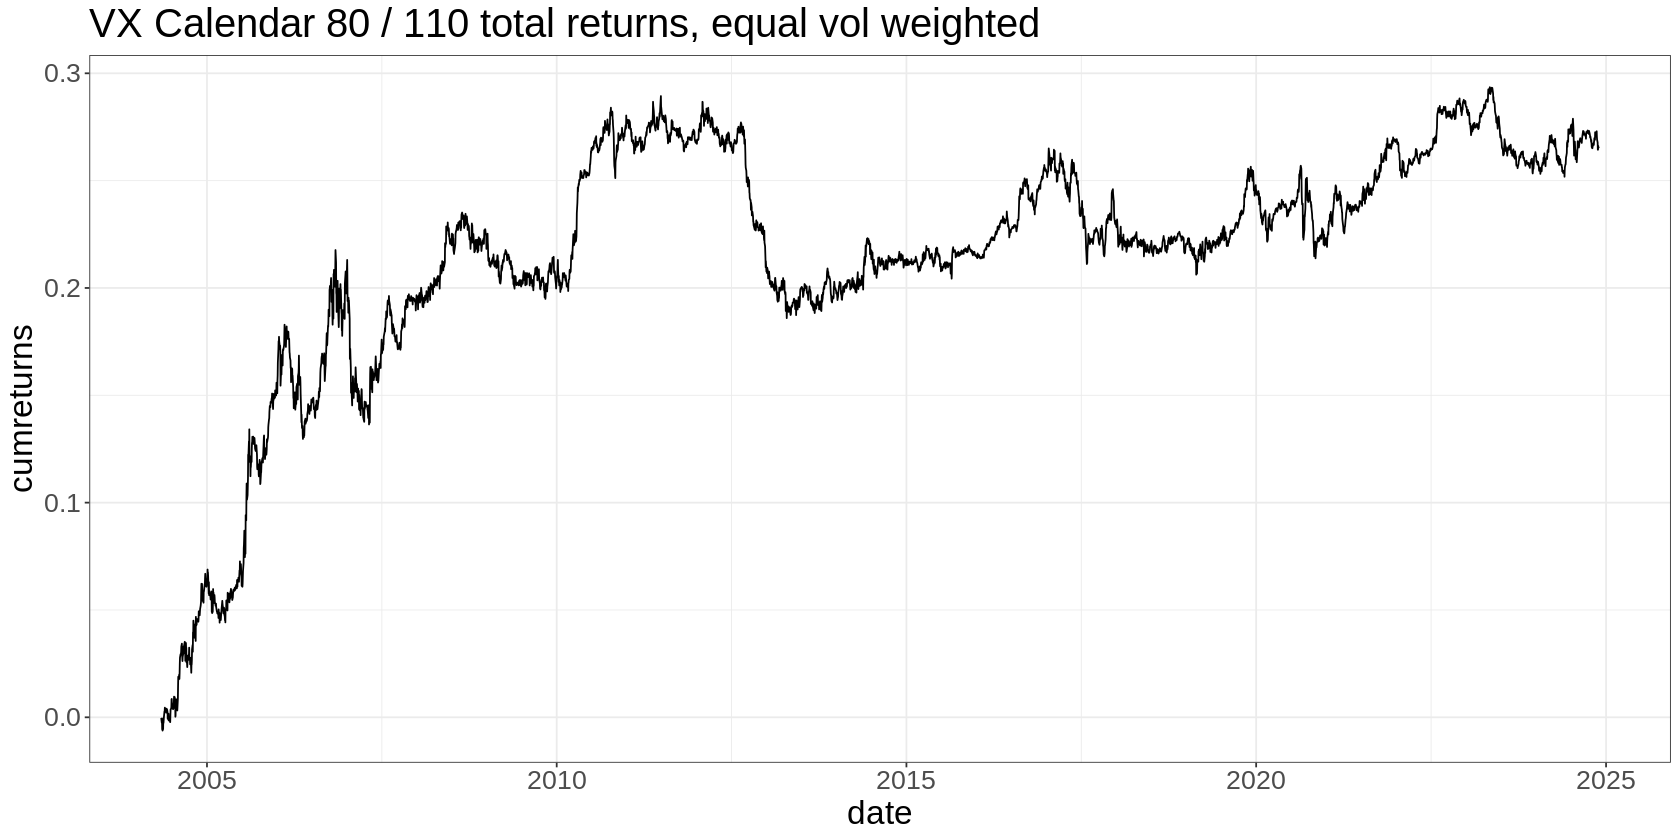

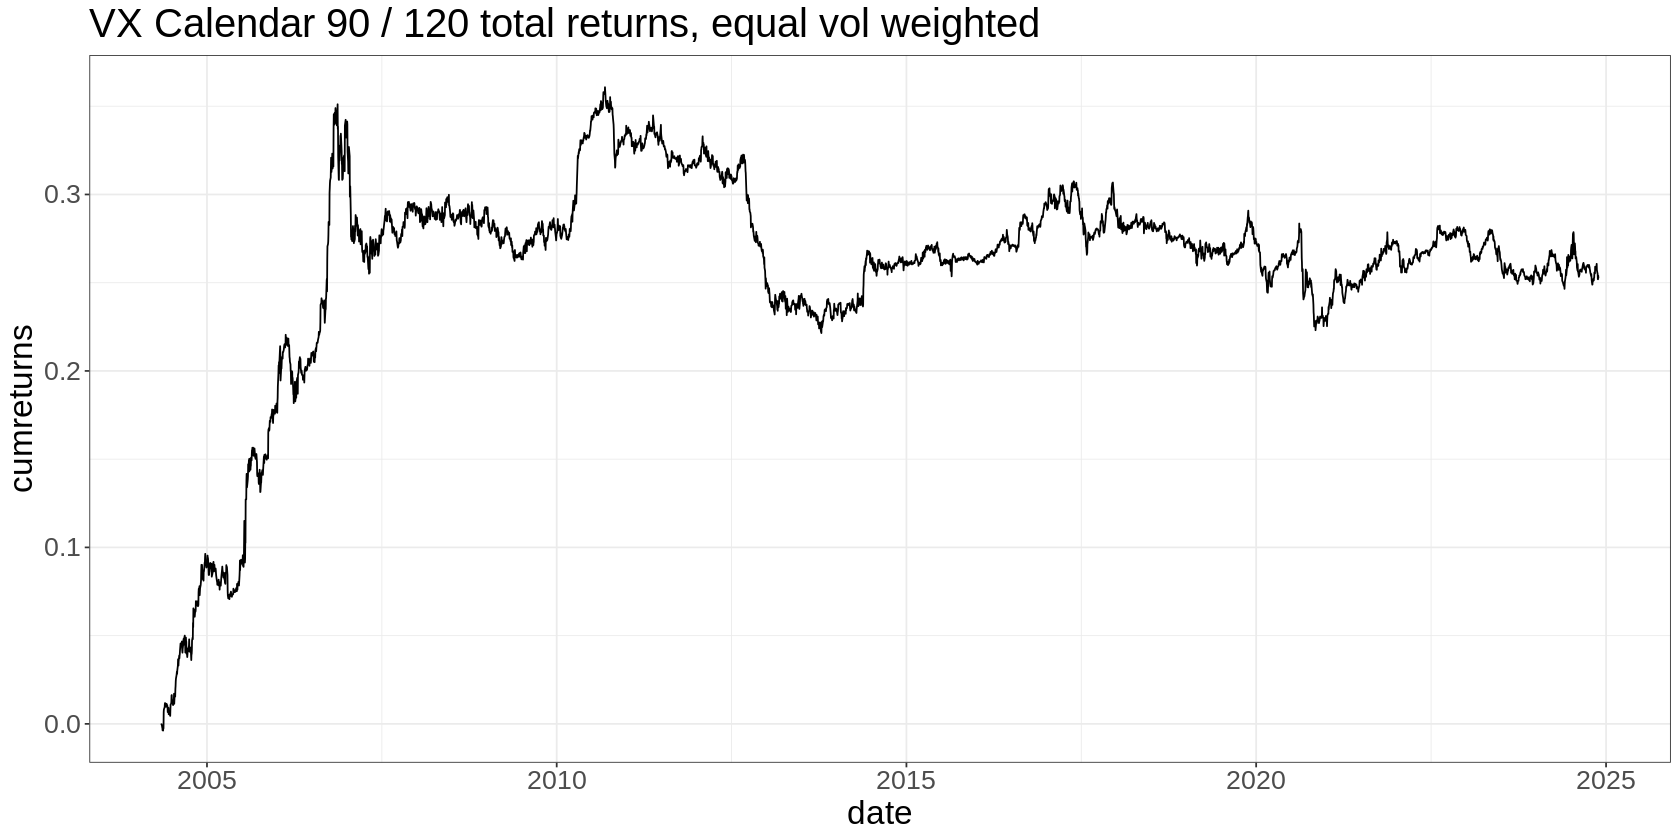

In [29]:
equal_vol_calendar_returns <- function(data, t_1, t_2) {
  front <- data %>% filter(t==t_1) %>% mutate(front_returns = -returns) %>% select(date, front_returns) %>%
    na.omit() %>%
    mutate(
      front_vol = roll::roll_sd(front_returns, 30) * sqrt(252),
      front_returns = (0.2 / front_vol) * front_returns
    )
  back <- data %>% filter(t==t_2) %>% mutate(back_returns = returns) %>% select(date, back_returns) %>%
    na.omit() %>%
    mutate(
      back_vol = roll::roll_sd(back_returns, 30) * sqrt(252),
      back_returns = (0.2 / back_vol) * back_returns
    )
  front %>% left_join(back, by='date') %>% mutate(returns = front_returns + back_returns)
}

plot_ev_calendar_returns <- function(data, t_1, t_2) {
  equal_vol_calendar_returns(const_multi, t_1, t_2) %>%
    na.omit() %>%
    arrange(date) %>%
    mutate(cumreturns = cumsum(log(1+returns))) %>%
    ggplot(aes(x=date, y=cumreturns)) + geom_line() + ggtitle(glue::glue('VX Calendar {t_1} / {t_2} total returns, equal vol weighted'))
}

plot1 <- plot_ev_calendar_returns(const_multi, 30, 60)
plot2 <- plot_ev_calendar_returns(const_multi, 40, 70)
plot3 <- plot_ev_calendar_returns(const_multi, 50, 80)
plot4 <- plot_ev_calendar_returns(const_multi, 60, 90)
plot5 <- plot_ev_calendar_returns(const_multi, 70, 100)
plot6 <- plot_ev_calendar_returns(const_multi, 80, 110)
plot7 <- plot_ev_calendar_returns(const_multi, 90, 120)

# Combine the plots in two columns
combined_plot <- (plot1 | plot2) /
                 (plot3 | plot4) /
                 (plot5 | plot6)
print(combined_plot)

print(plot1)
print(plot2)
print(plot3)
print(plot4)
print(plot5)
print(plot6)
print(plot7)

Just allowing it to lean net short vol is probably a good idea.

Is there any evidence that the slope is predictive of calendar returns?